In [1]:
import numpy as np

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import emulator

from nbodykit.lab import cosmology

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import wCDM
from astropy.cosmology import FlatwCDM

### Build emulators

In [2]:
statistic = 'upf'
traintag = '_nonolap'
testtag = '_mean_test0'
errtag = '_100hod_test0'
log = True
mean = False
nhod = 100
kernel_name = 'M32ExpConst'
tag = f'_log_k{kernel_name}_{nhod}hod'

gptag = traintag + errtag + tag
acctag = gptag + testtag

res_dir = '../../clust/results_{}/'.format(statistic)
gperr = np.loadtxt(res_dir+"{}_error{}.dat".format(statistic, errtag))

training_dir = '{}training_{}{}/'.format(res_dir, statistic, traintag)
hyperparams = "../training_results/{}_training_results{}.dat".format(statistic, gptag)

#testing_dir = '{}testing_{}{}/'.format(res_dir, statistic, testtag)

emu_upf = emulator.Emulator(statistic, training_dir, gperr=gperr, log=log, mean=mean, 
                            nhod=nhod, hyperparams=hyperparams, kernel_name=kernel_name)

george version: 0.3.1
Loading training data
Nparams: 18


In [3]:
emu_upf.build()

Rebuilding emulators


In [4]:
statistic = 'wp'
traintag = '_nonolap'
testtag = '_mean_test0'
errtag = '_100hod_test0'
log = True
mean = False
nhod = 100
kernel_name = 'M32ExpConst2'
tag = f'_log_k{kernel_name}_{nhod}hod'

gptag = traintag + errtag + tag
acctag = gptag + testtag

res_dir = '../../clust/results_{}/'.format(statistic)
gperr = np.loadtxt(res_dir+"{}_error{}.dat".format(statistic, errtag))

training_dir = '{}training_{}{}/'.format(res_dir, statistic, traintag)
hyperparams = "../training_results/{}_training_results{}.dat".format(statistic, gptag)

testing_dir = '{}testing_{}{}/'.format(res_dir, statistic, testtag)

emu_wp = emulator.Emulator(statistic, training_dir, gperr=gperr, hyperparams=hyperparams, 
                           log=log, mean=mean, nhod=nhod, kernel_name=kernel_name)

george version: 0.3.1
Loading training data
Nparams: 18


In [5]:
emu_wp.build()

Rebuilding emulators


In [6]:
rmin = 0.1
rmax = 50
nbins = 9
rbins = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1) # Note the + 1 to nbins
r_logavg = 10 ** (0.5 * (np.log10(rbins)[1:] + np.log10(rbins)[:-1]))

In [7]:
r_upf = np.linspace(5, 45, 9)
r_upf

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45.])

In [8]:
hods_test = np.loadtxt("/mount/sirocco2/zz681/emulator/CMASSLOWZ/test_galaxy_mocks_wp_RSD/test_galaxy_mocks_new_f_env/HOD_test_np11_n1000_new_f_env.dat")
nhodparams_test = hods_test.shape[1]
hods_test[:,0] = np.log10(hods_test[:,0])
hods_test[:,2] = np.log10(hods_test[:,2])
cosmos_test = np.loadtxt("../CMASS/Gaussian_Process/hod_file/cosmology_camb_test_box_full.dat")
ncosmoparams_test = cosmos_test.shape[1]
nparams_test = nhodparams_test + ncosmoparams_test

In [7]:
print(hods_test.shape)
print(cosmos_test.shape)

(1000, 11)
(7, 7)


In [8]:
hod_mean = np.mean(hods_test, axis=0)
print(hod_mean.shape)
cosmo_mean = np.mean(cosmos_test, axis=0)
print(cosmo_mean.shape)
params_mean = np.concatenate((cosmo_mean, hod_mean))
print(params_mean.shape)

(11,)
(7,)
(18,)


In [9]:
pdict_mean = {}
param_names_ordered = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w',
                        'M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f',
                        'f_env', 'delta_env', 'sigma_env']
for i in range(len(param_names_ordered)):
    print("{}: {:.3f}".format(param_names_ordered[i], params_mean[i]))
    pdict_mean[param_names_ordered[i]] = params_mean[i]

Omega_m: 0.302
Omega_b: 0.048
sigma_8: 0.806
h: 0.682
n_s: 0.963
N_eff: 3.450
w: -0.997
M_sat: 14.154
alpha: 1.012
M_cut: 11.849
sigma_logM: 0.323
v_bc: 0.352
v_bs: 1.085
c_vir: 1.100
f: 1.004
f_env: 0.004
delta_env: 1.251
sigma_env: 0.546


In [10]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [11]:
pdict_mean

{'Omega_m': 0.3018442857142857,
 'Omega_b': 0.04824398571428572,
 'sigma_8': 0.8058088571428572,
 'h': 0.682317,
 'n_s': 0.9625150000000001,
 'N_eff': 3.4499999999999997,
 'w': -0.9965127142857143,
 'M_sat': 14.15351517106943,
 'alpha': 1.0121550539,
 'M_cut': 11.84886983807495,
 'sigma_logM': 0.32304270724000034,
 'v_bc': 0.35214283716430034,
 'v_bs': 1.0850441469000012,
 'c_vir': 1.0995841902000008,
 'f': 1.0038609099999987,
 'f_env': 0.003558546714400002,
 'delta_env': 1.2506969546,
 'sigma_env': 0.5459776326000003}

In [17]:
statistics = ['wp', 'upf']
stats_ylabels = [r'$w_p$($r_p$)', r'P$_U$(r)']
stats_meanlabels = [r'$w_p$($r_p$)/$w_{p,\mathrm{mean}}$($r_p$)', r'P$_U$(r)/P$_{U,\mathrm{mean}}$(r)']
stats_xlabels = ["r (Mpc/h)", "r (Mpc/h)"]
emus = [emu_wp, emu_upf]

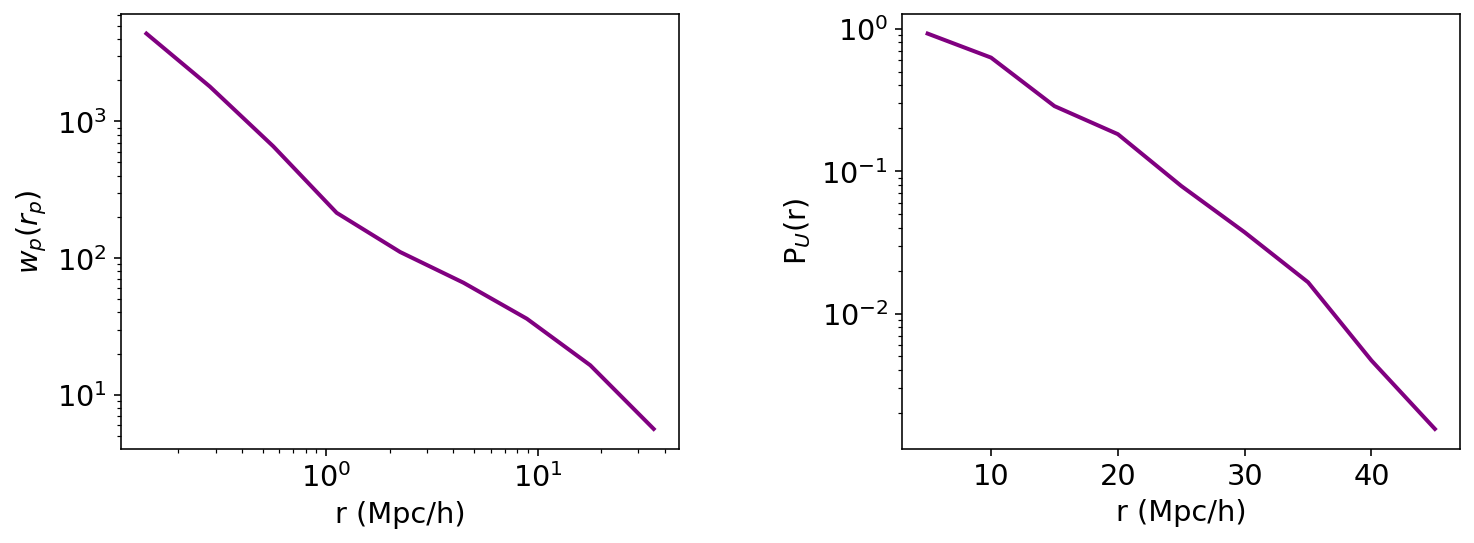

In [15]:
ncols = 2
figsize = (12,4)
fig, axarr = plt.subplots(1, ncols, figsize=figsize)
plt.subplots_adjust(wspace=0.4)

for j in range(ncols):
    ax = axarr[j]
    emu = emus[j]
    statistic = statistics[j]
    pred = emu.predict(pdict_mean)

    if statistic=='wp':
    
        xvals = r_logavg
    elif statistic=='upf':
        xvals = r_upf
        
    ax.plot(xvals, pred, lw=2, color='purple')
    
    #ax.set_xlim(min(xvals[j]), max(xvals[j]))

    ax.set_xlabel(stats_xlabels[j])
    ax.set_yscale("log") 
    ax.set_ylabel(stats_ylabels[j])

    if statistic == 'wp':
        ax.set_xscale('log')

Omega_m
Omega_b
sigma_8
h
n_s
N_eff
w
M_sat
alpha
M_cut
sigma_logM
v_bc
v_bs
c_vir
f
f_env
delta_env
sigma_env


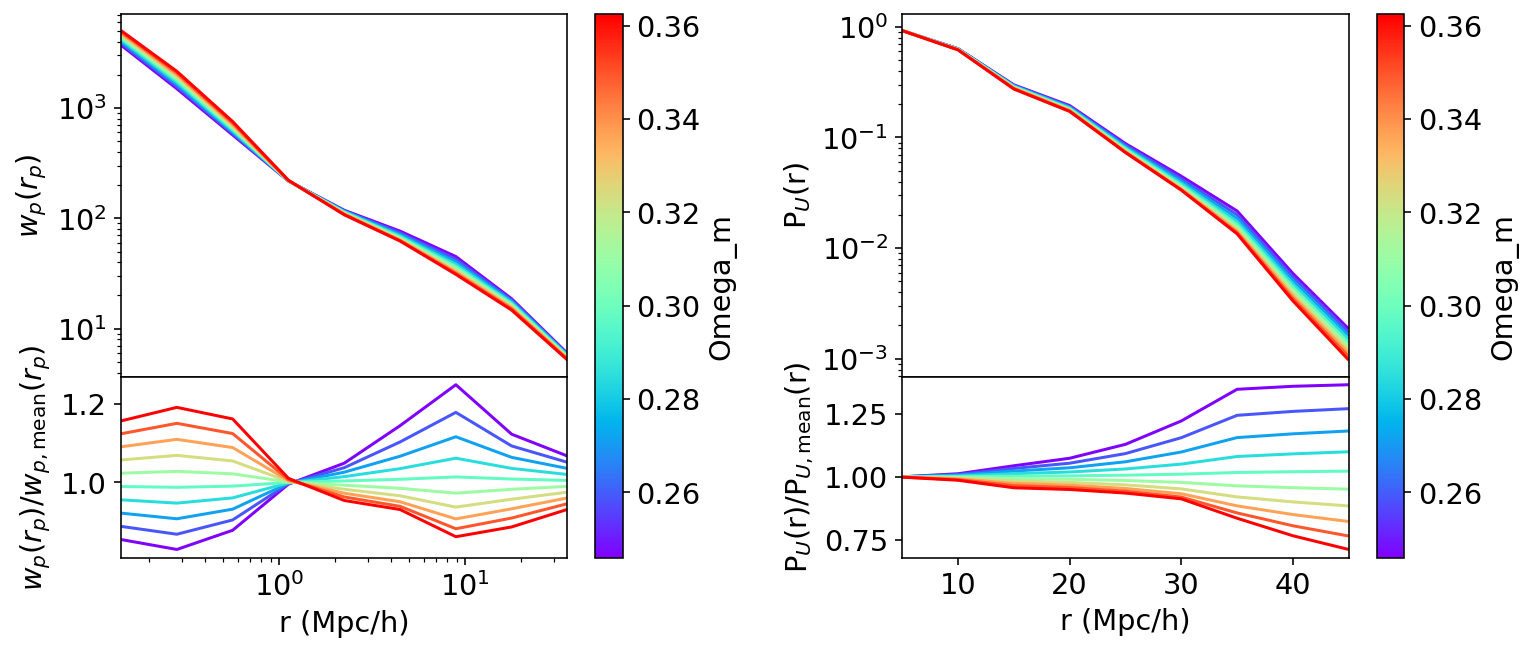

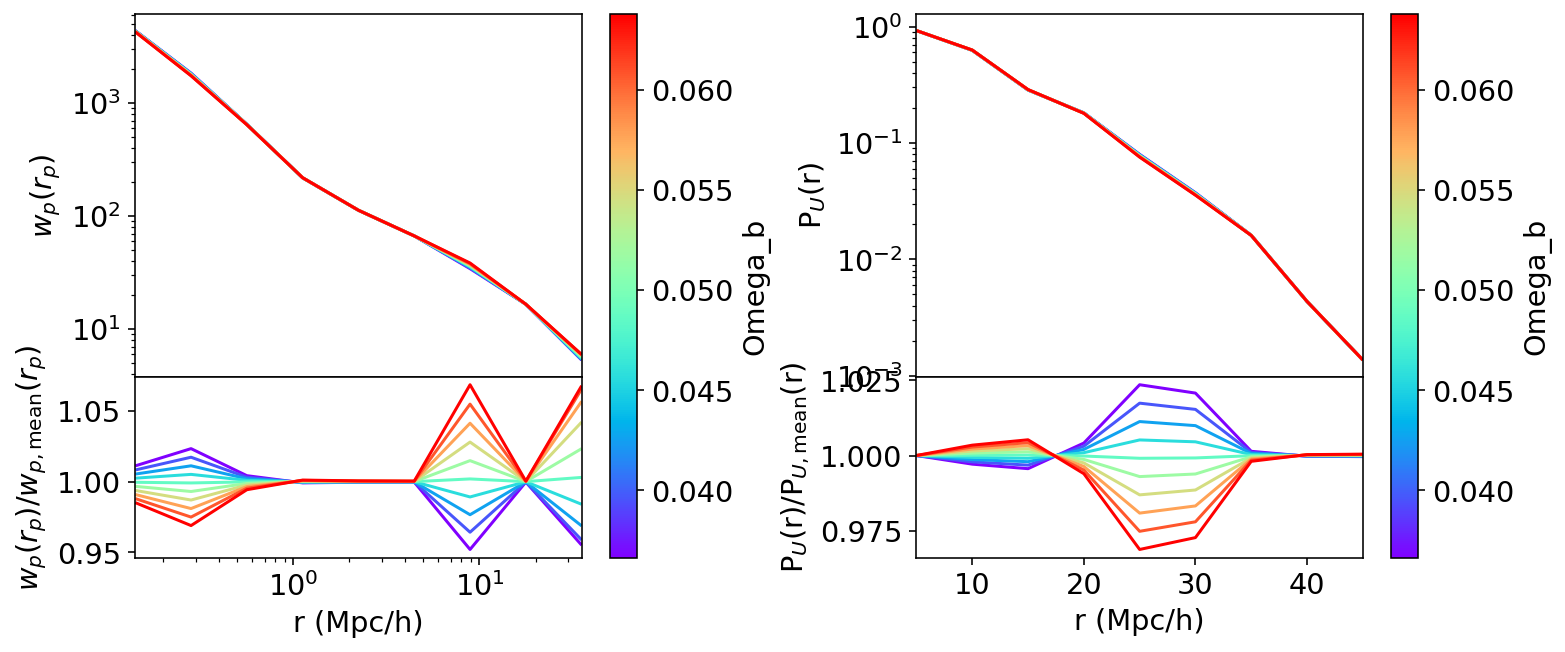

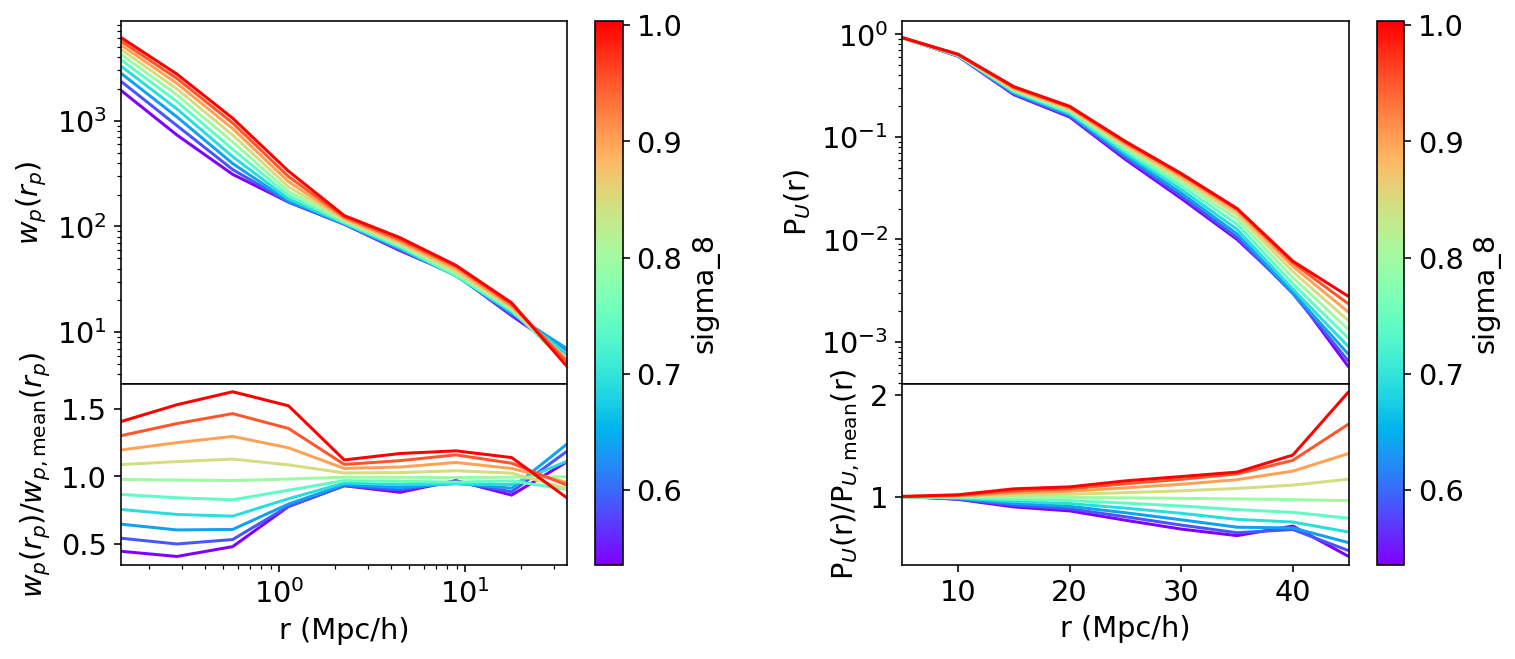

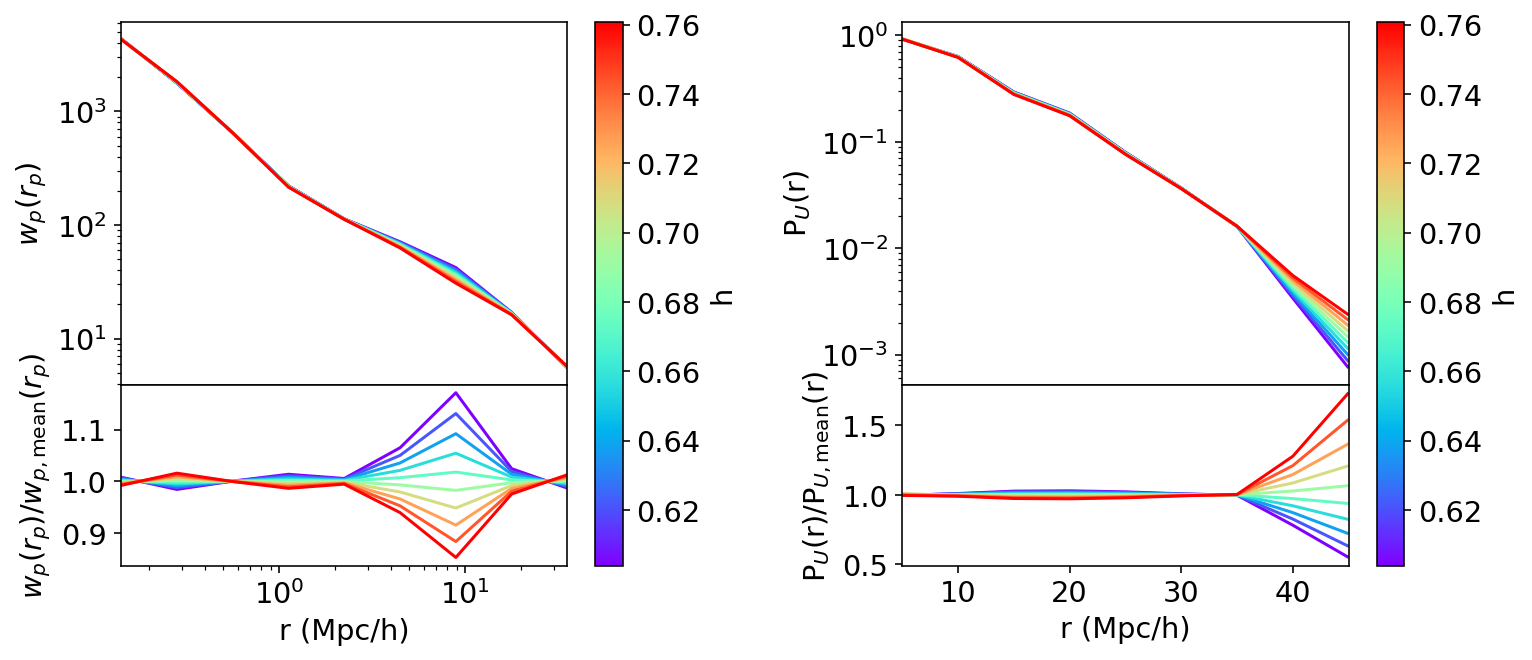

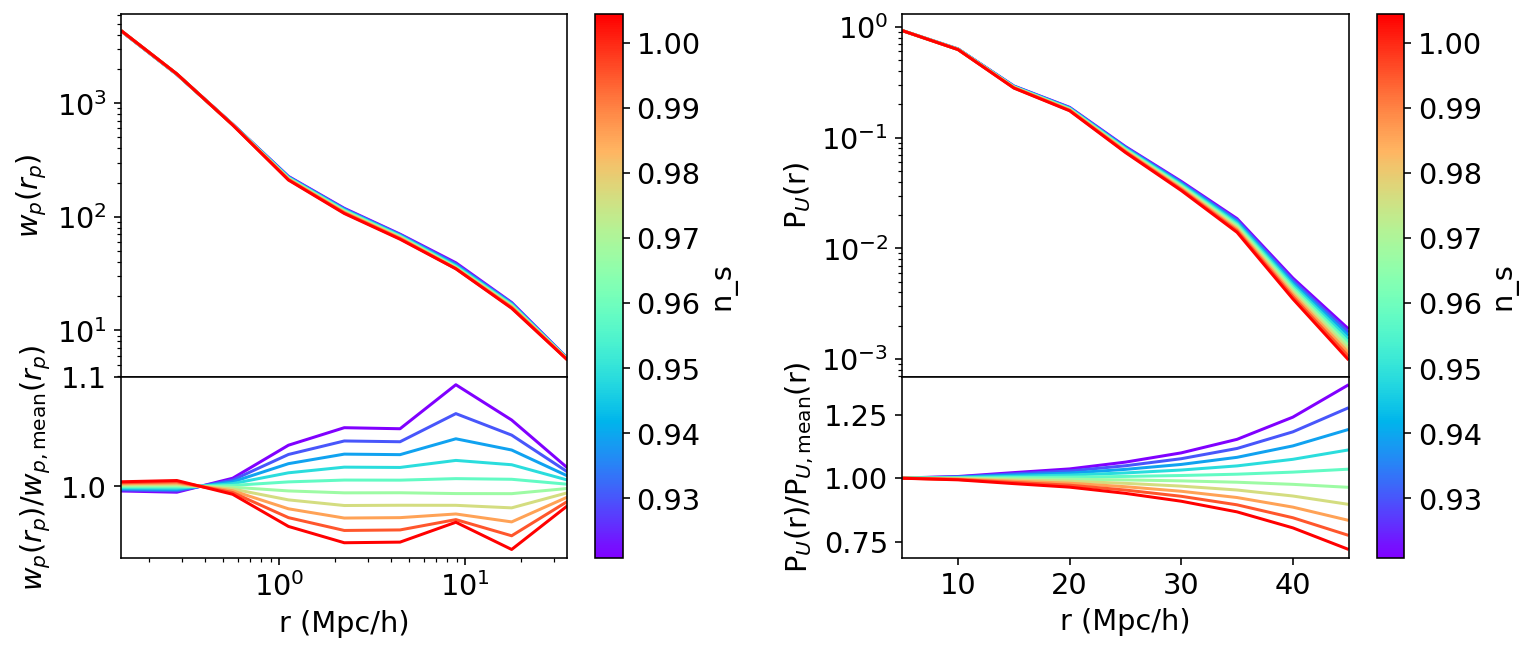

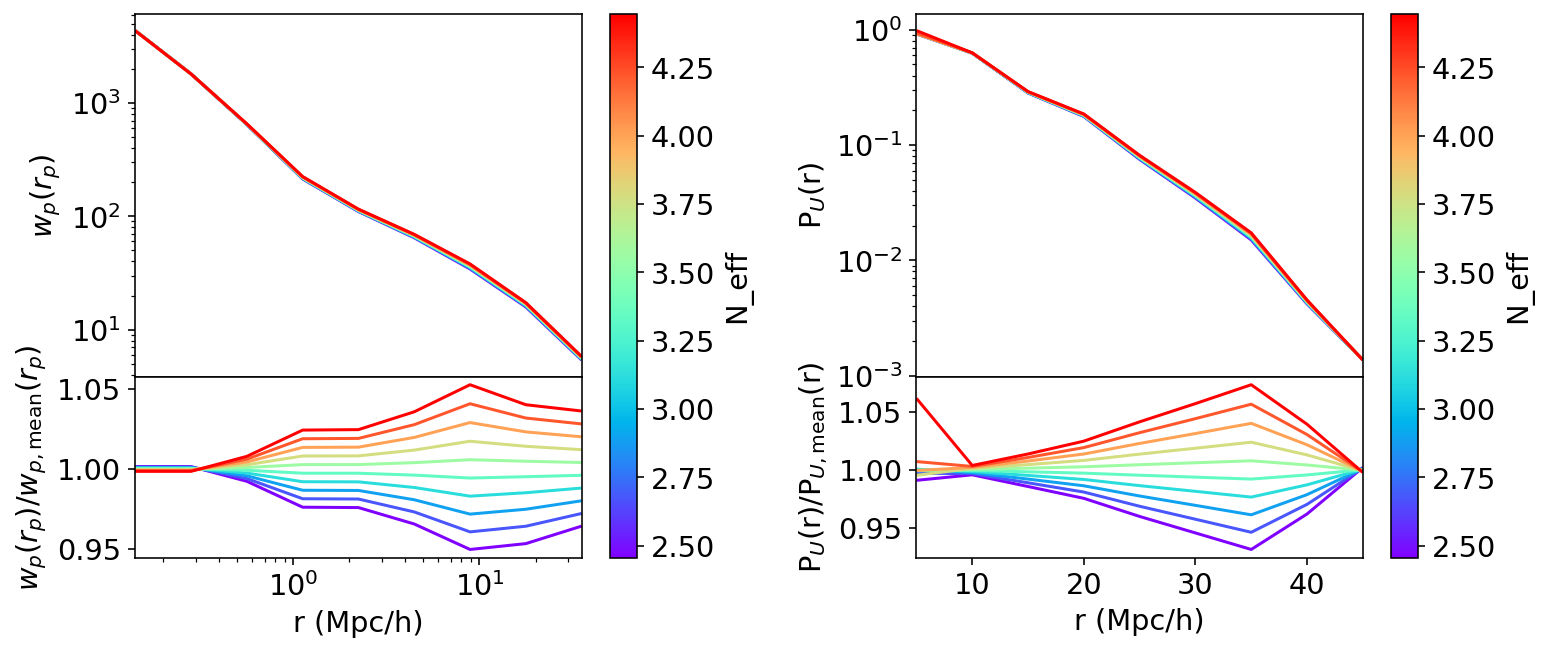

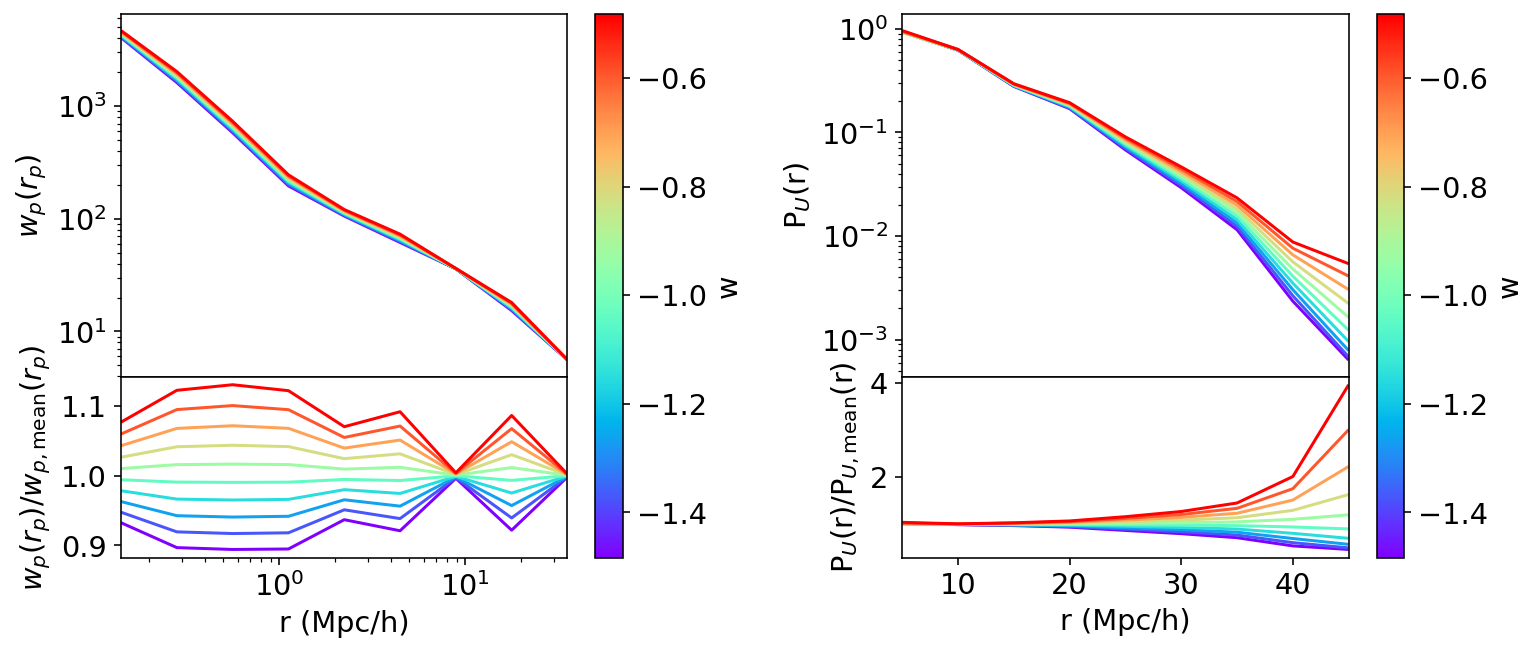

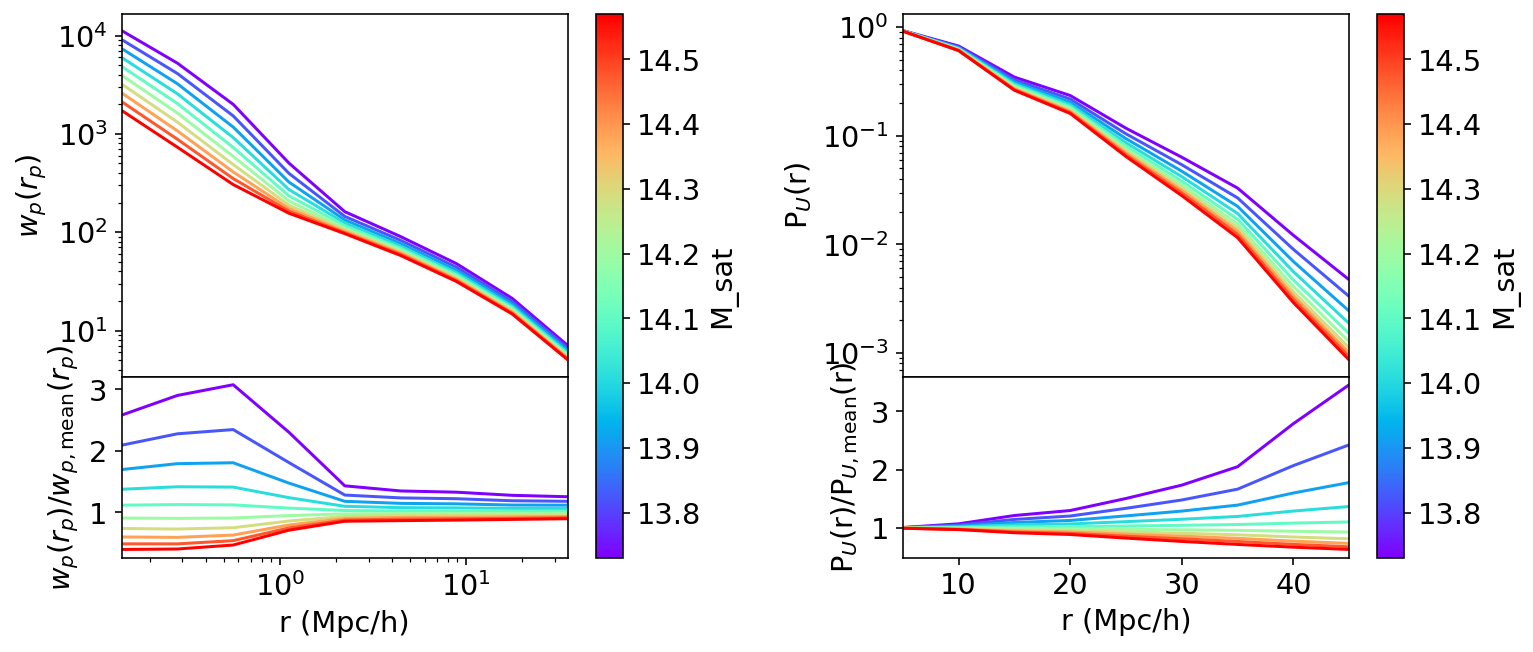

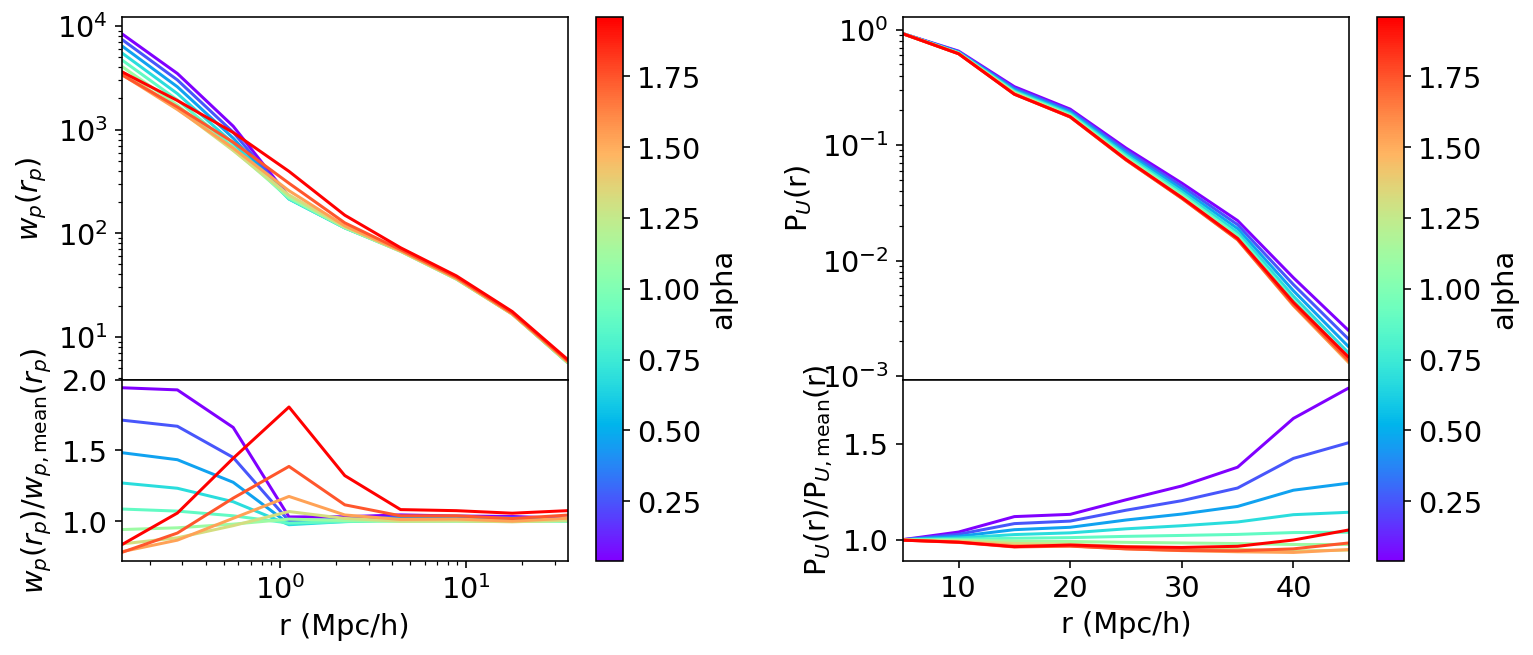

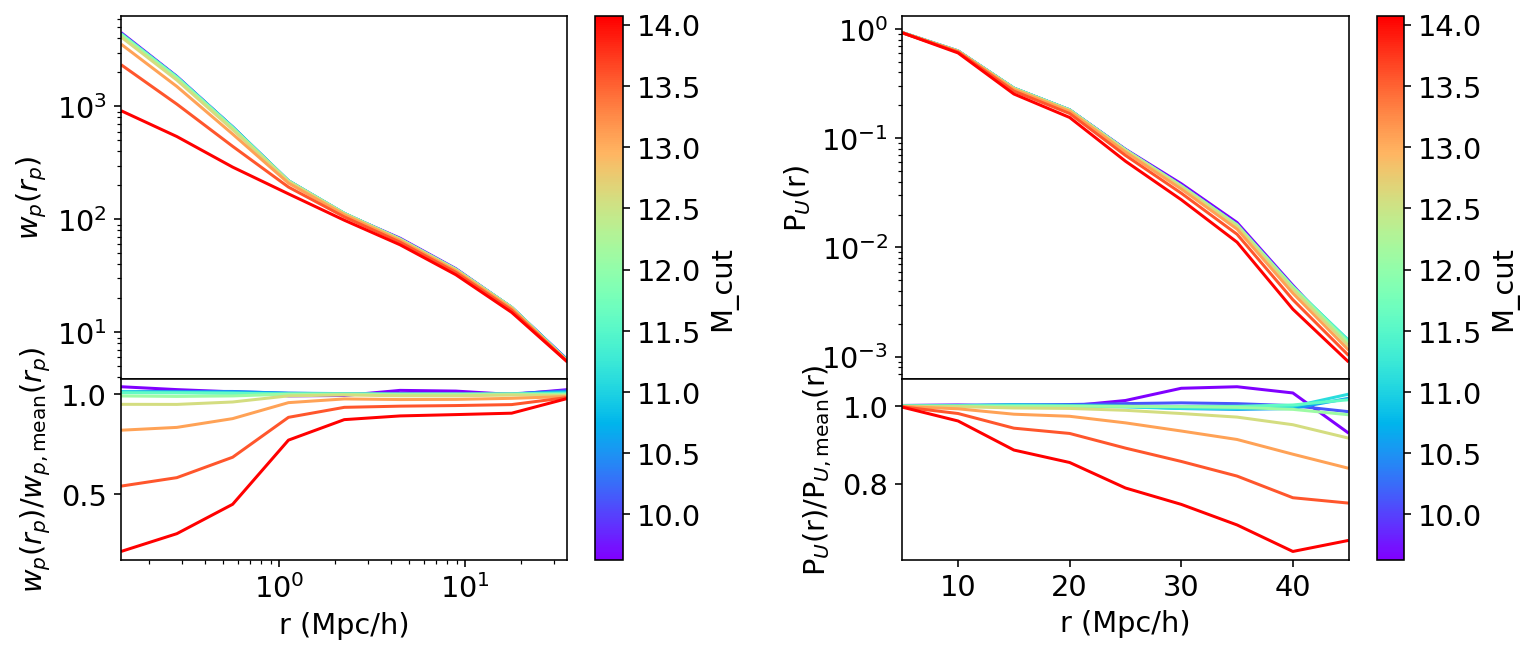

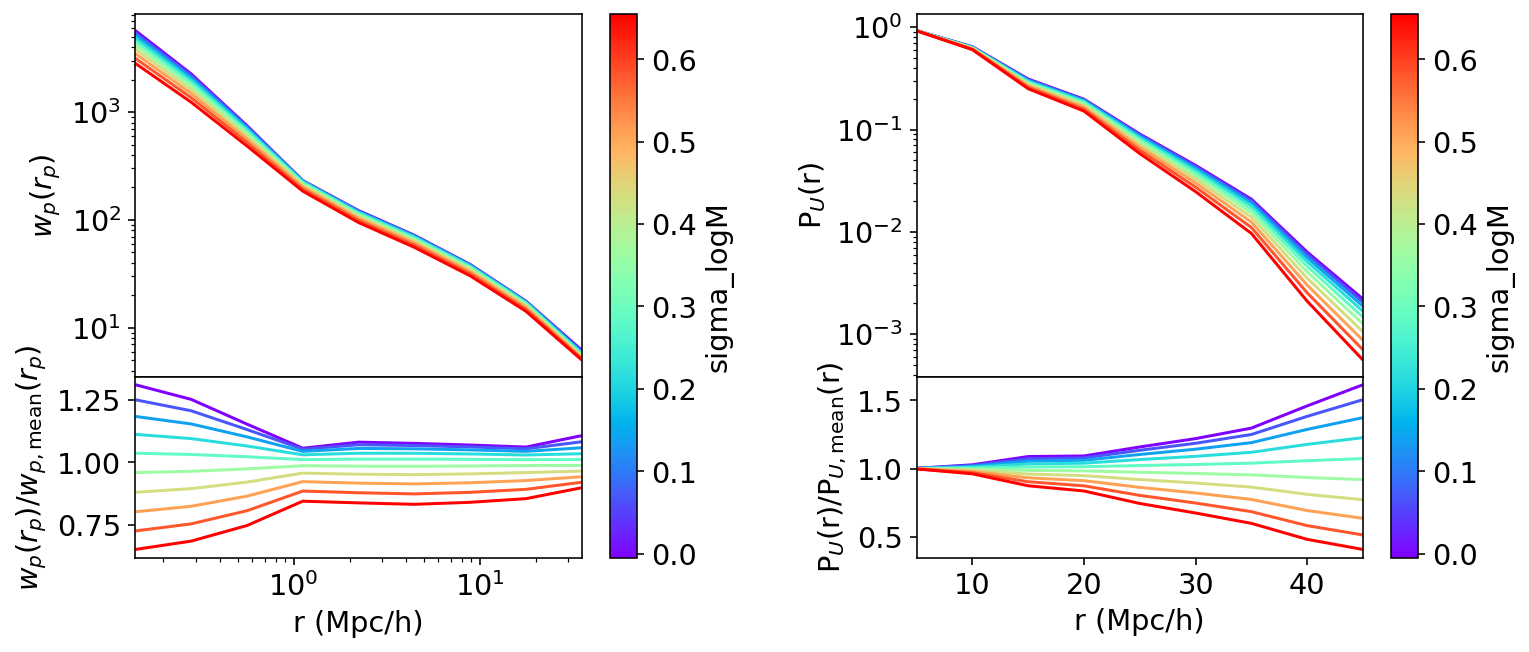

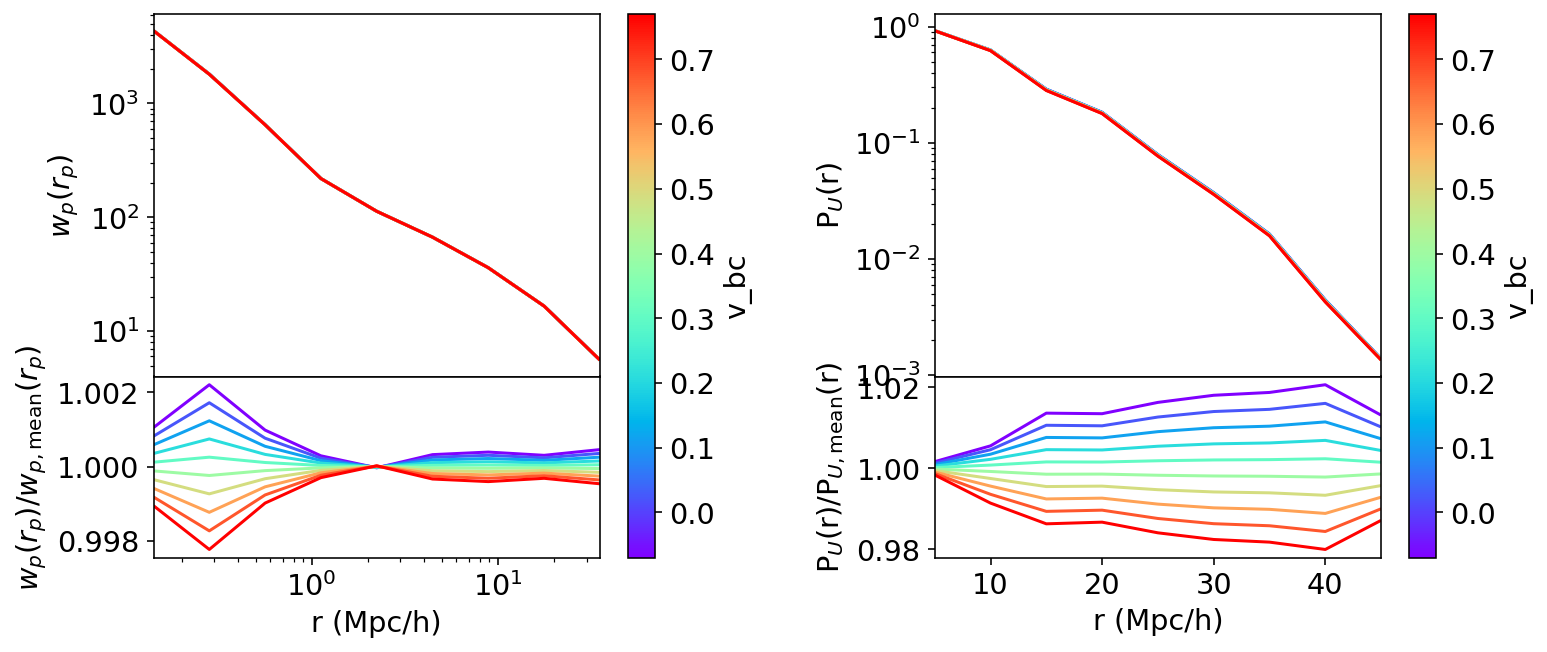

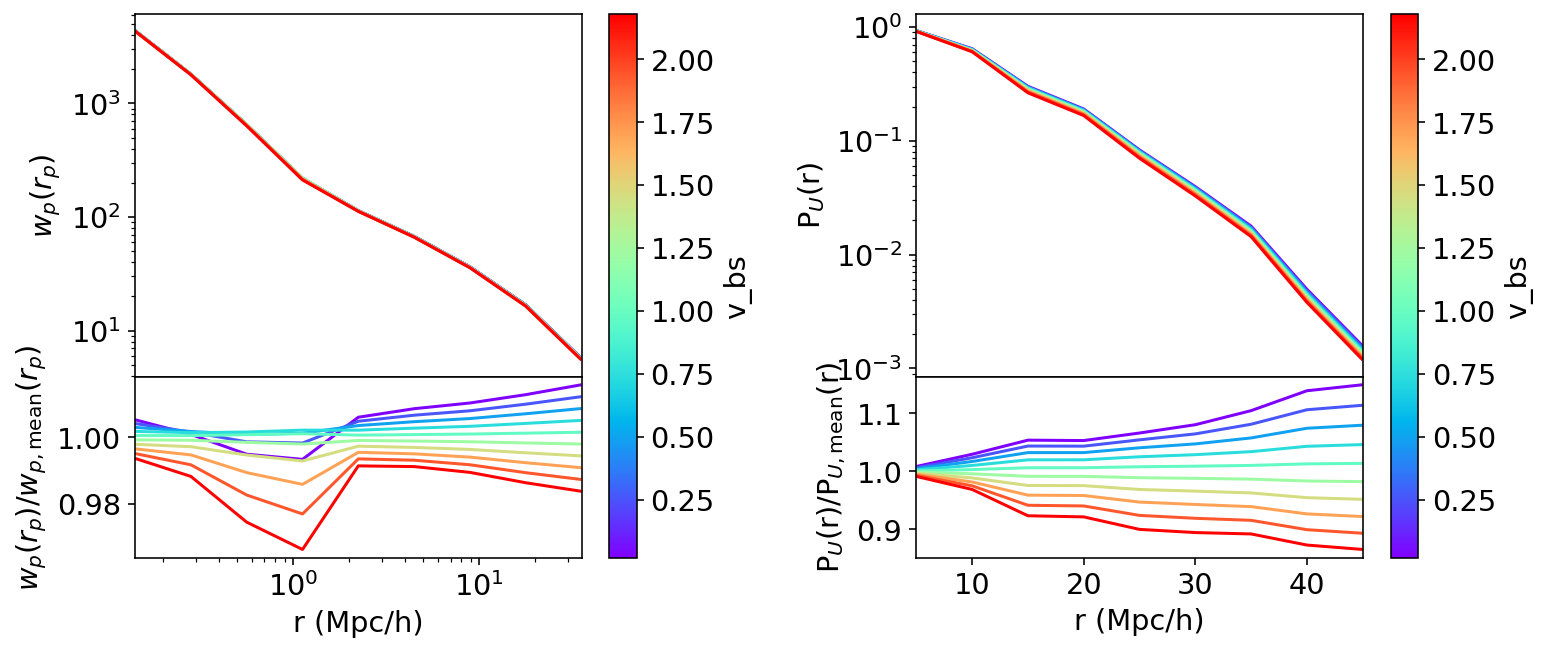

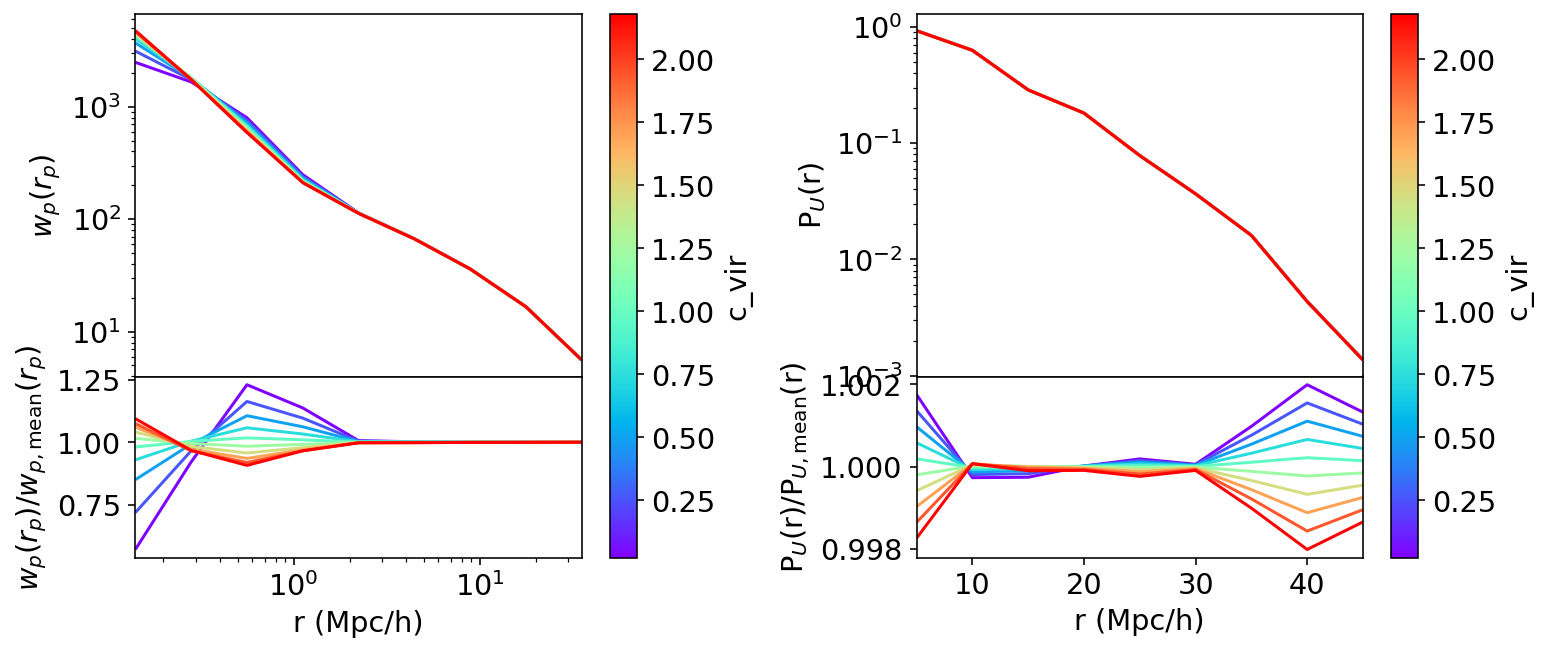

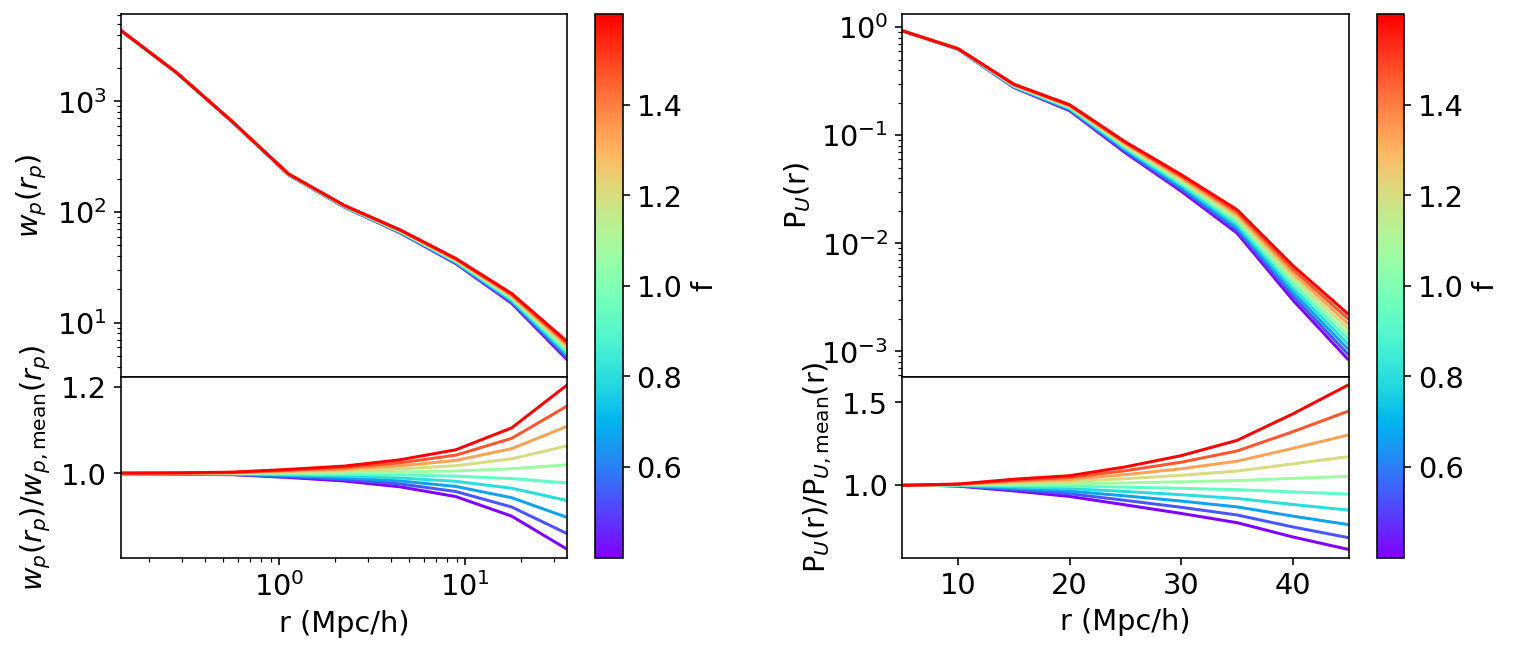

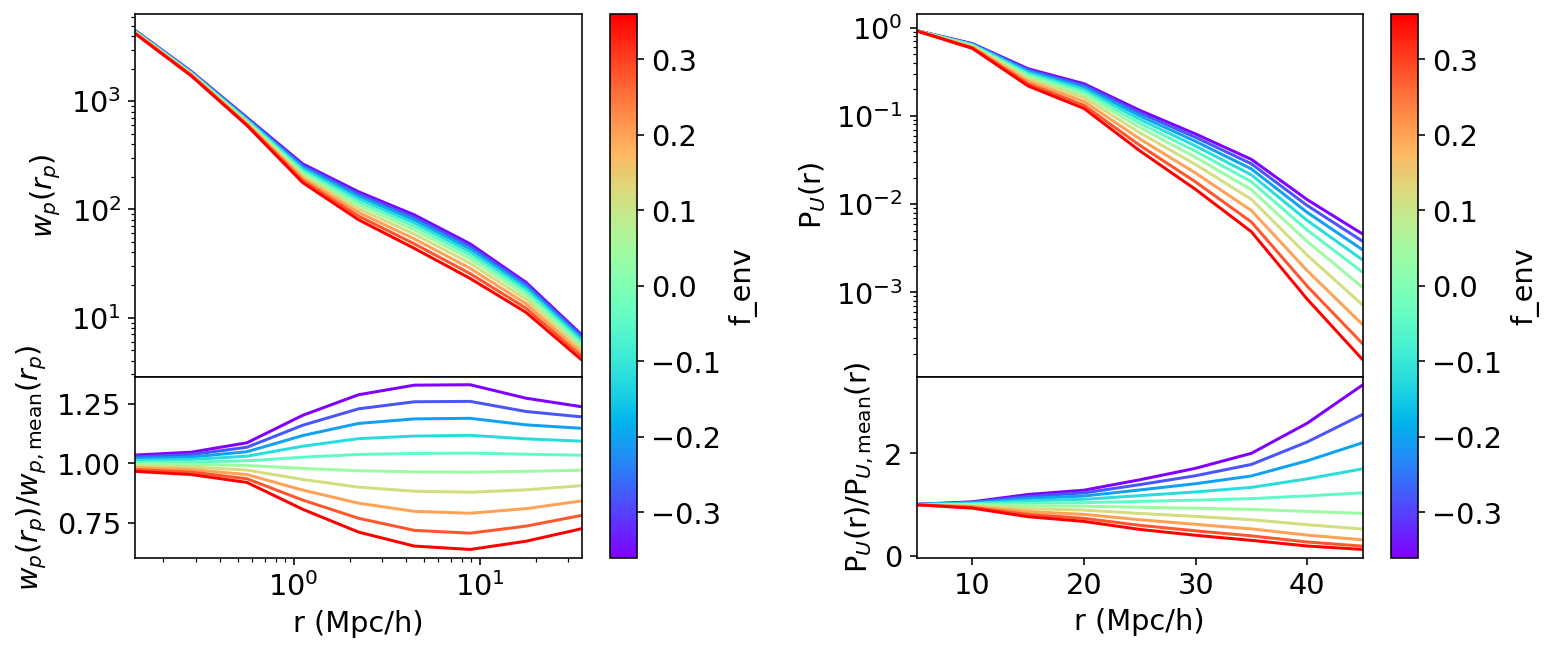

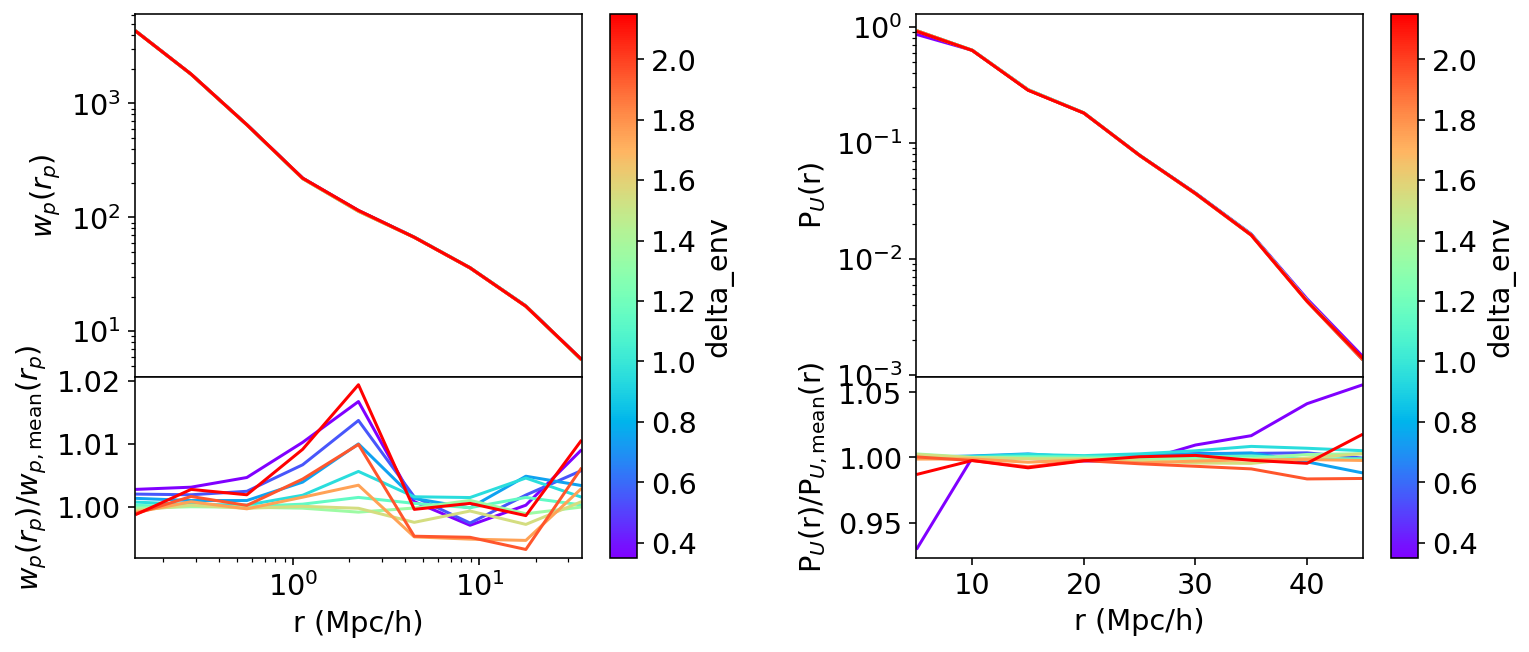

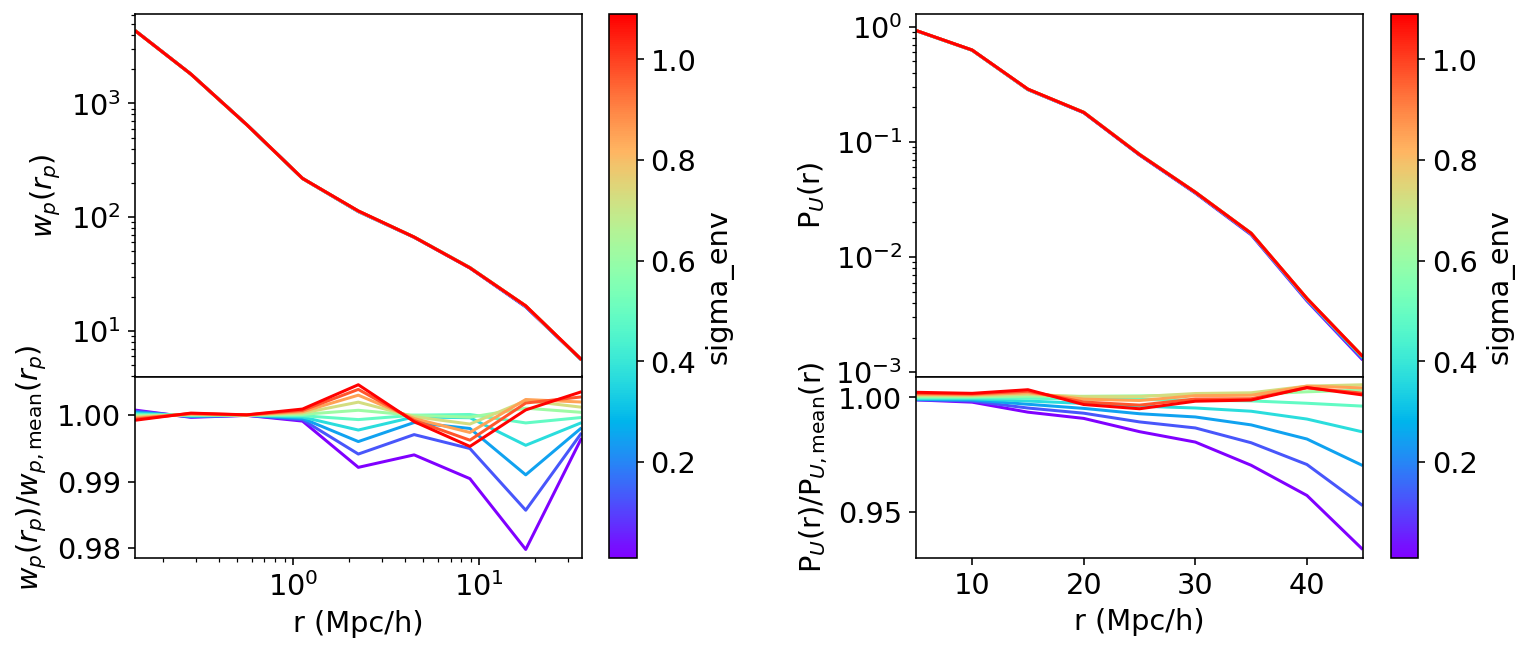

In [19]:
wp_base = emu_wp.predict(pdict_mean)
upf_base = emu_upf.predict(pdict_mean)
stats_base = [wp_base, upf_base]

nrows = len(pdict_mean.keys())
#nrows = 2
ncols = len(emus)

figsize = (12,5)
#panel_size = (4,7)
#figsize = (panel_size[1]*ncols, panel_size[0]*nrows)
#fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
#plt.subplots_adjust(wspace=0.3)
for i in range(nrows):
    
    fig, axarr = plt.subplots(2, ncols, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]})
    plt.subplots_adjust(hspace=0, wspace=0.4)
    
    pn = param_names_ordered[i]
    print(pn)
    #vals = np.linspace(0.2, 0.4, 2)
    val_mean = pdict_mean[pn]
    
    for j in range(ncols):
        emu = emus[j]
        statistic = statistics[j]
        #ax = axarr[i][j]

        preds = []
        xvals = []

        #vals = np.linspace(0.7*val_mean, 1.3*val_mean, 10)
        pmin, pmax = emu.get_param_bounds(pn)
        #if pn=='M_cut' or pn=='M_sat':
        #    pmin = np.log10(pmin)
        #    pmax = np.log10(pmax)
        vals = np.linspace(pmin, pmax, 10)
        pdict = pdict_mean.copy()
        
        for val in vals:
            pdict[pn] = val
            pred = emu.predict(pdict)
            if statistic=='wp':
                xvals.append(r_logavg)
            elif statistic=='upf':
                xvals.append(r_upf)
            
            preds.append(pred)

        axtop = axarr[0][j]
        axbot = axarr[1][j]

        lc = multiline(xvals, preds, vals, cmap='rainbow', ax=axtop)
        ratio = preds/stats_base[j]
        lc = multiline(xvals, ratio, vals, cmap='rainbow', ax=axbot)


        axcb = fig.colorbar(lc, ax=[axtop,axbot])
        axcb.set_label(pn)
        
        axbot.set_xlabel(stats_xlabels[j])
        axtop.set_xticks([])
        
        axtop.set_xlim(min(xvals[j]), max(xvals[j]))
        axbot.set_xlim(min(xvals[j]), max(xvals[j]))

        axtop.set_yscale("log") 
        axtop.set_ylabel(stats_ylabels[j])
        axbot.set_ylabel(stats_meanlabels[j])

        if statistic == 'wp':
            axtop.set_xscale('log')
            axbot.set_xscale('log')            
            
            

## Now check out theoretical model

In [17]:
def build_cosmo(pname=None, pval=None):
    pdict_copy = pdict_mean.copy()
    if pname is not None:
        pdict_copy[pname] = pval
    
    OmL = 1 - pdict_copy['Omega_m'] - pdict_copy['Omega_b']
    cosmo_base = cosmology.Cosmology(Omega0_cdm=pdict_copy['Omega_m'],
                      Omega0_b=pdict_copy['Omega_b'],
                      n_s=pdict_copy['n_s'],
                      h=pdict_copy['h'],
                      #Omega_Lambda=0.0,
                      )
    cosmo_base = cosmology.Cosmology.clone(cosmo_base,
                      sigma8=pdict_copy['sigma_8'],
                      Neff=pdict_copy['N_eff'],
                      w=pdict_copy['w'],
                      #wa_fld = 0.,
                      #cs2_fld = 1
                      )
                                    
    return cosmo_base

In [18]:
s = np.logspace(-1, 2.2, 300)
k = np.logspace(-4, 1, 300)

cosmo_base = build_cosmo()

for key,val in cosmo_base:
    print(f'{key}: {val}')

redshift = 0
Plin = cosmology.LinearPower(cosmo_base, redshift, transfer='EisensteinHu')
CF = cosmology.correlation.CorrelationFunction(Plin)
pk_base = Plin(k)
xi_base = CF(s)

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): Neff, w
  self.engine = ClassEngine(pars)


output: vTk dTk mPk
extra metric transfer functions: y
h: 0.682317
N_ur: 2.0328
gauge: synchronous
n_s: 0.9625150000000001
T_cmb: 2.7255
Omega_cdm: 0.3018442857142857
Omega_b: 0.04824398571428572
N_ncdm: 1
P_k_max_h/Mpc: 10.0
z_max_pk: 100.0
sigma8: 0.8058088571428572
Neff: 3.4499999999999997
w: -0.9965127142857143
m_ncdm: [0.06]


In [19]:
# cosmo2 = build_cosmo('w', -0.5)
# Plin2 = cosmology.LinearPower(cosmo2, redshift, transfer='EisensteinHu')
# CF2 = cosmology.correlation.CorrelationFunction(Plin2)
# xi2 = CF(s)
# for key,val in cosmo2:
#     print(f'{key}: {val}')

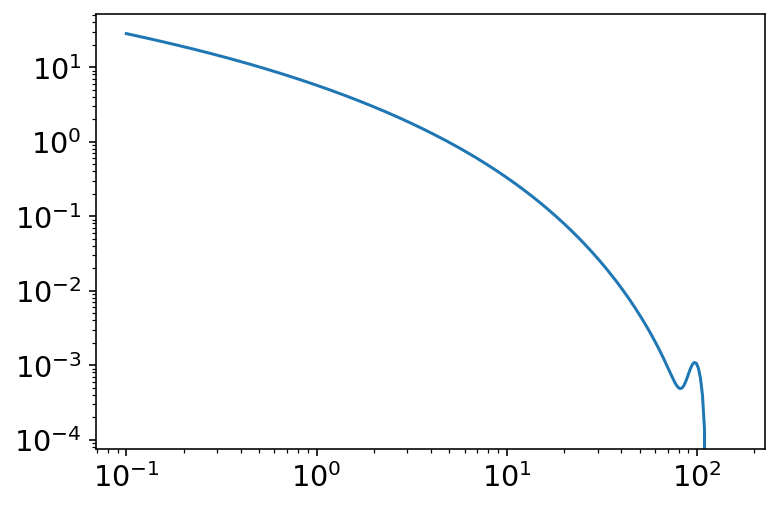

In [20]:
plt.plot(s, xi_base)
#plt.plot(s, xi2, color='magenta')
plt.xscale('log')
plt.yscale('log')

In [21]:
params = ['Omega_cdm', 'Omega_b', 'sigma_8', 'h', 'n_s']#, 'N_eff', 'w']
params_emuname = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s']#, 'N_eff', 'w']

#params = ['Omega_cdm','sigma_8']
#params_emuname = ['Omega_m', 'sigma_8']

Omega_cdm
0.2460299
0.2751332
0.3042365
0.3333398
0.3624431
Omega_b
0.03664212
0.043423260000000005
0.0502044
0.05698554
0.06376668
sigma_8
0.53564914
0.65259622
0.7695433
0.88649038
1.00343746
h
0.6038742
0.6430926
0.682311
0.7215294
0.7607478
n_s
0.92088586
0.94176688
0.9626478999999999
0.9835289199999999
1.00440994


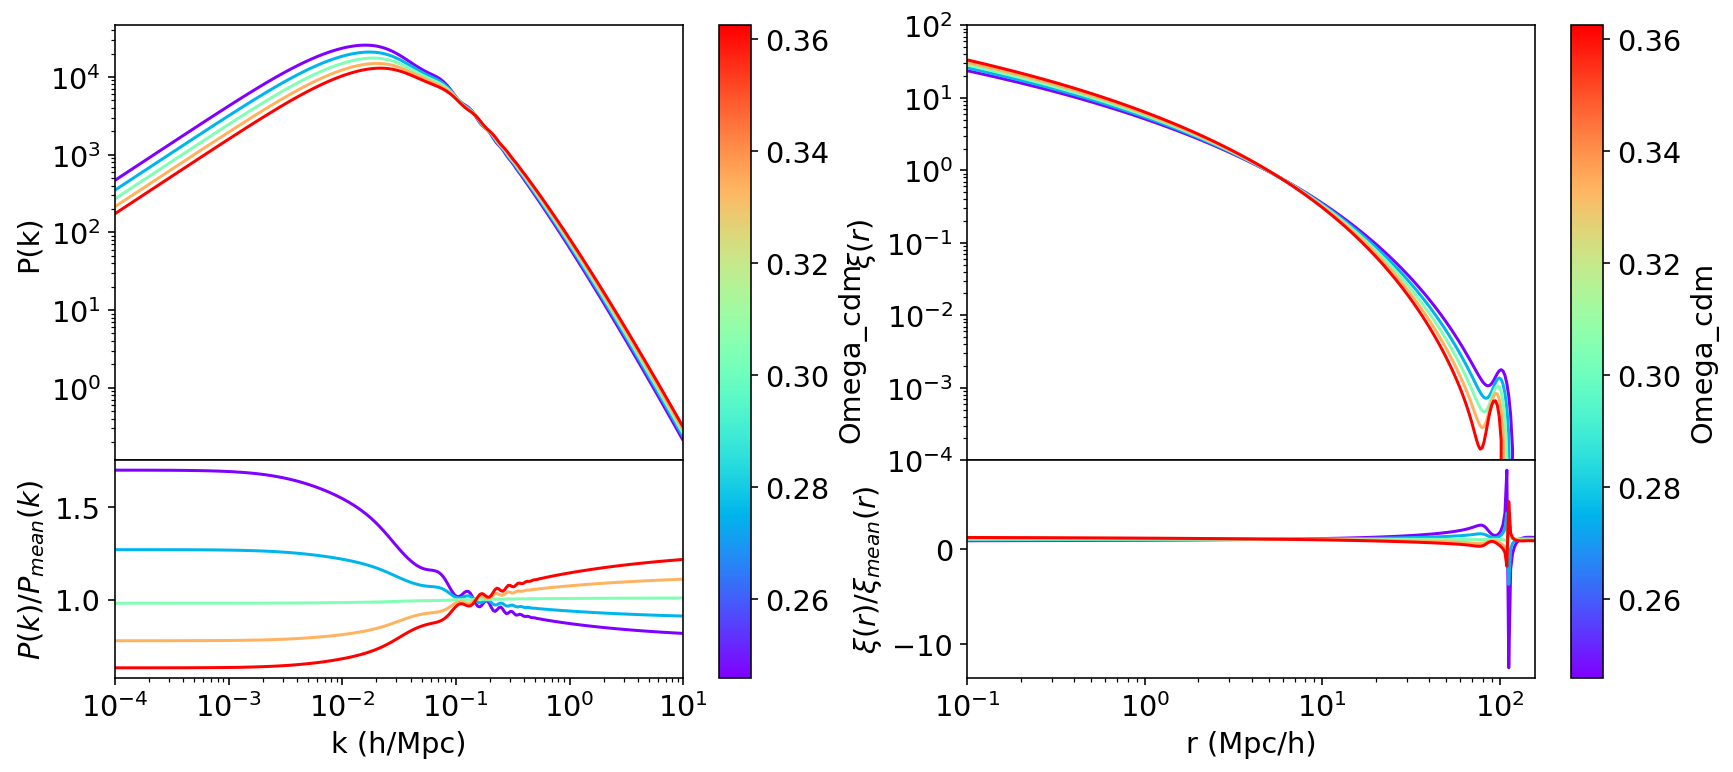

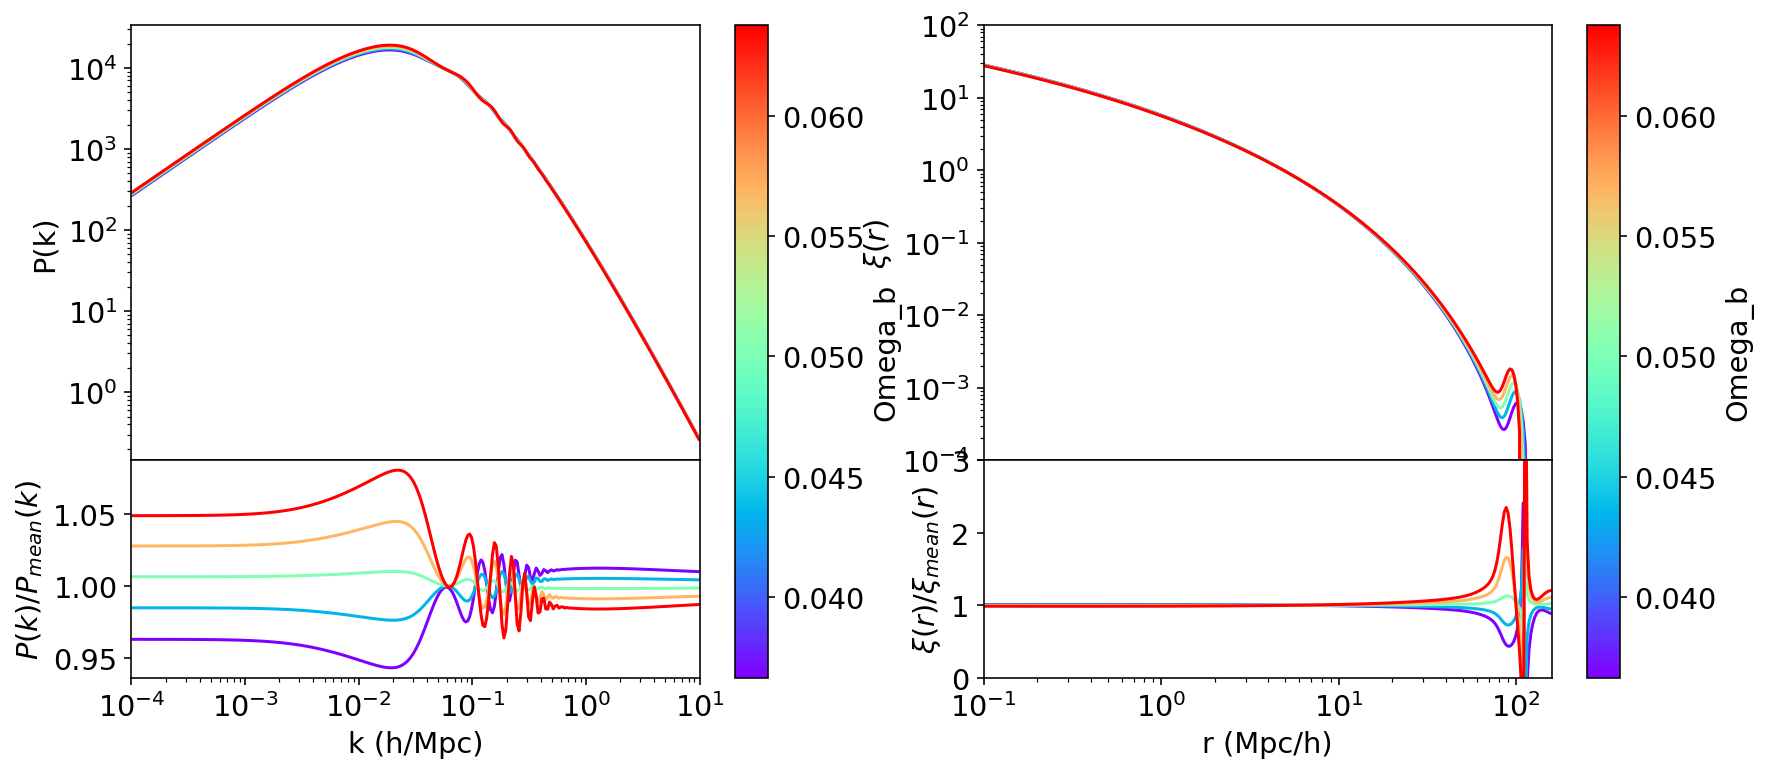

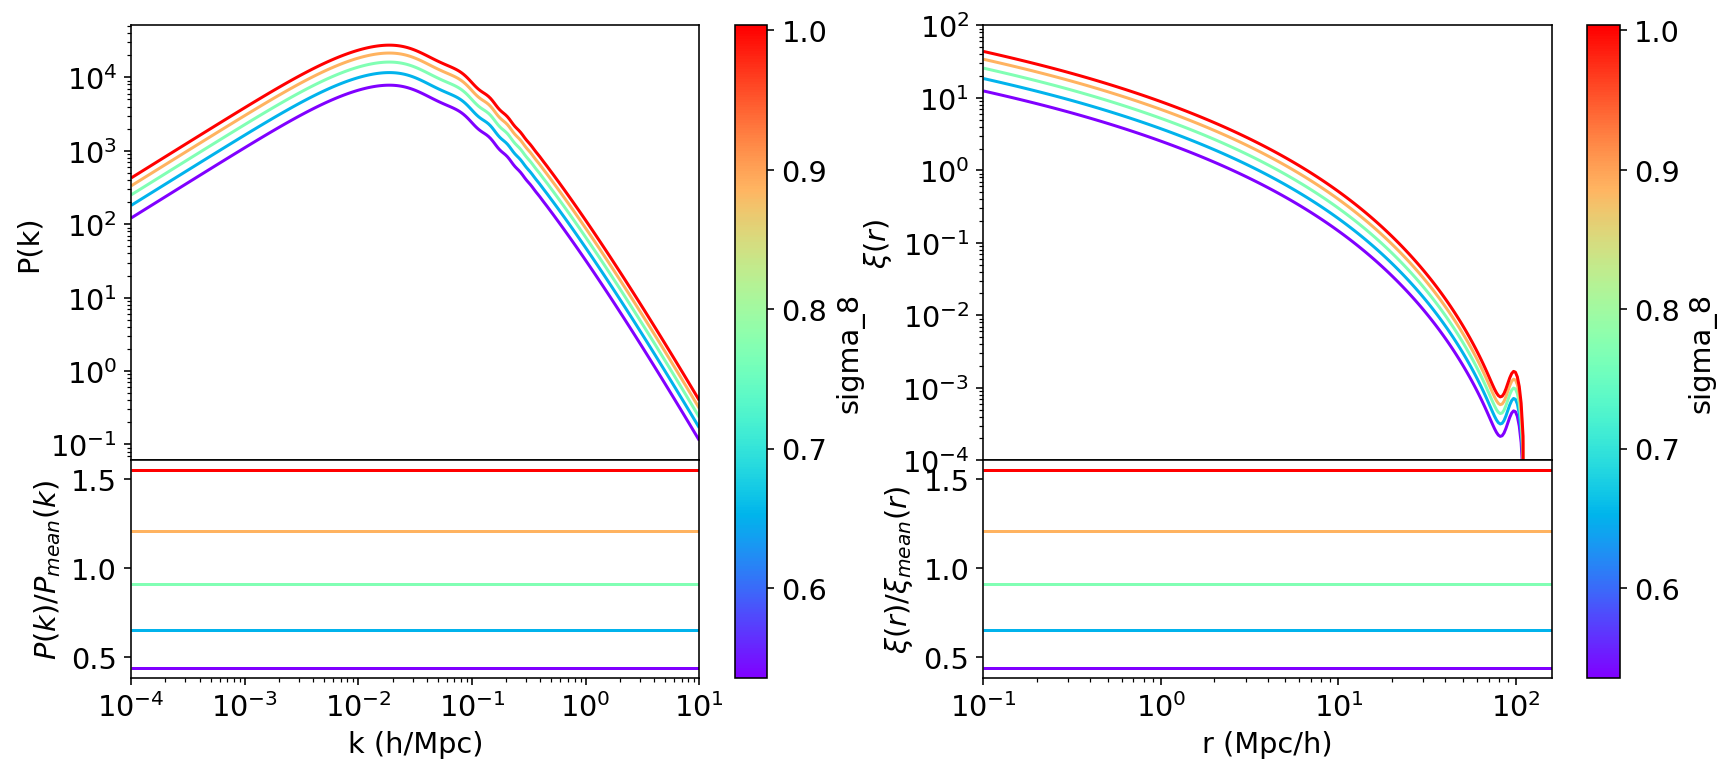

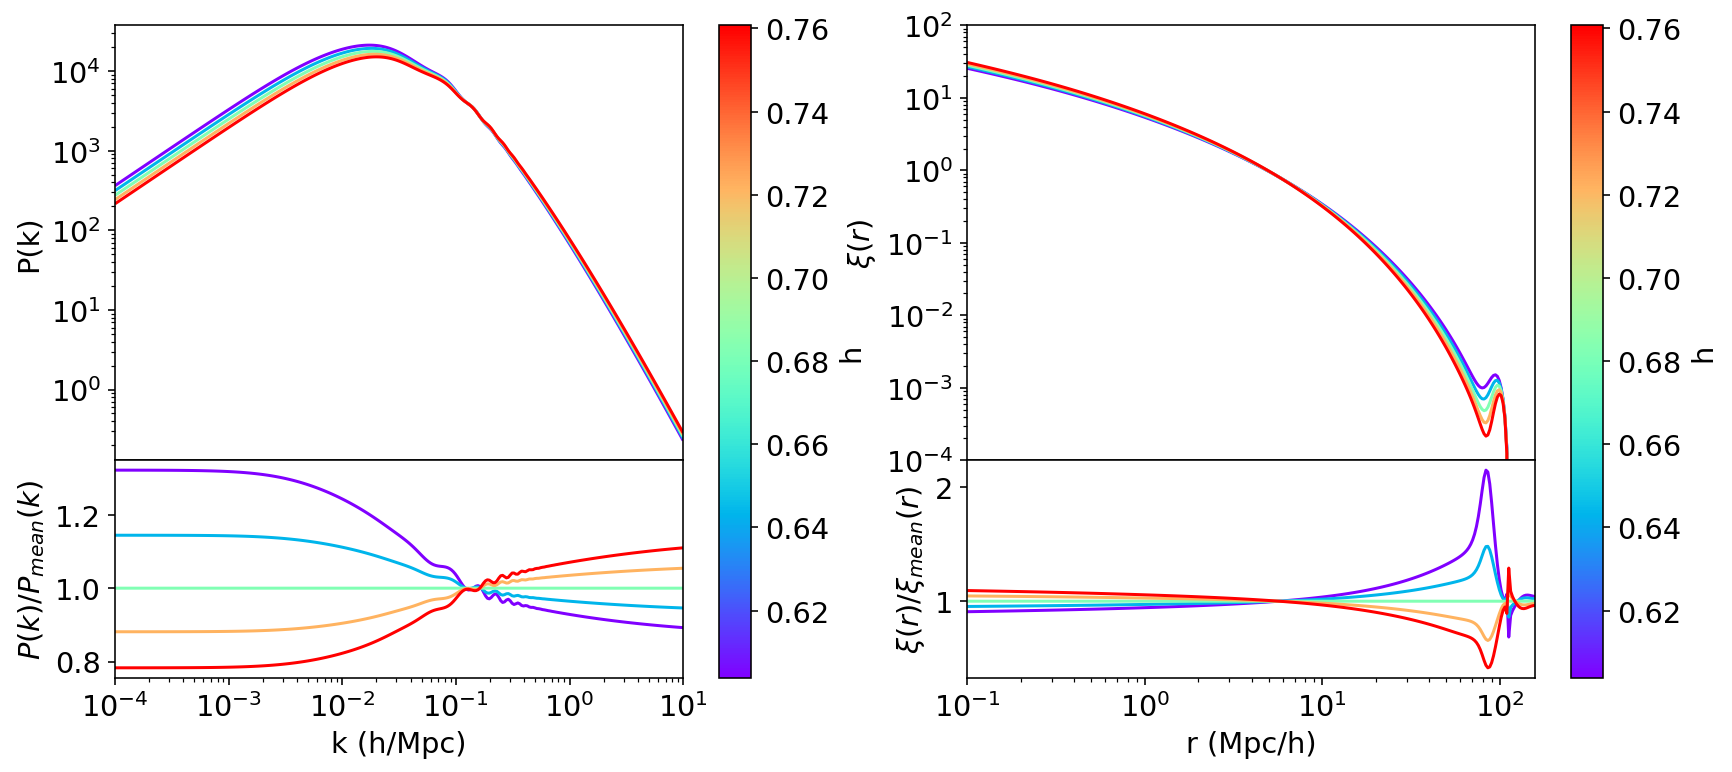

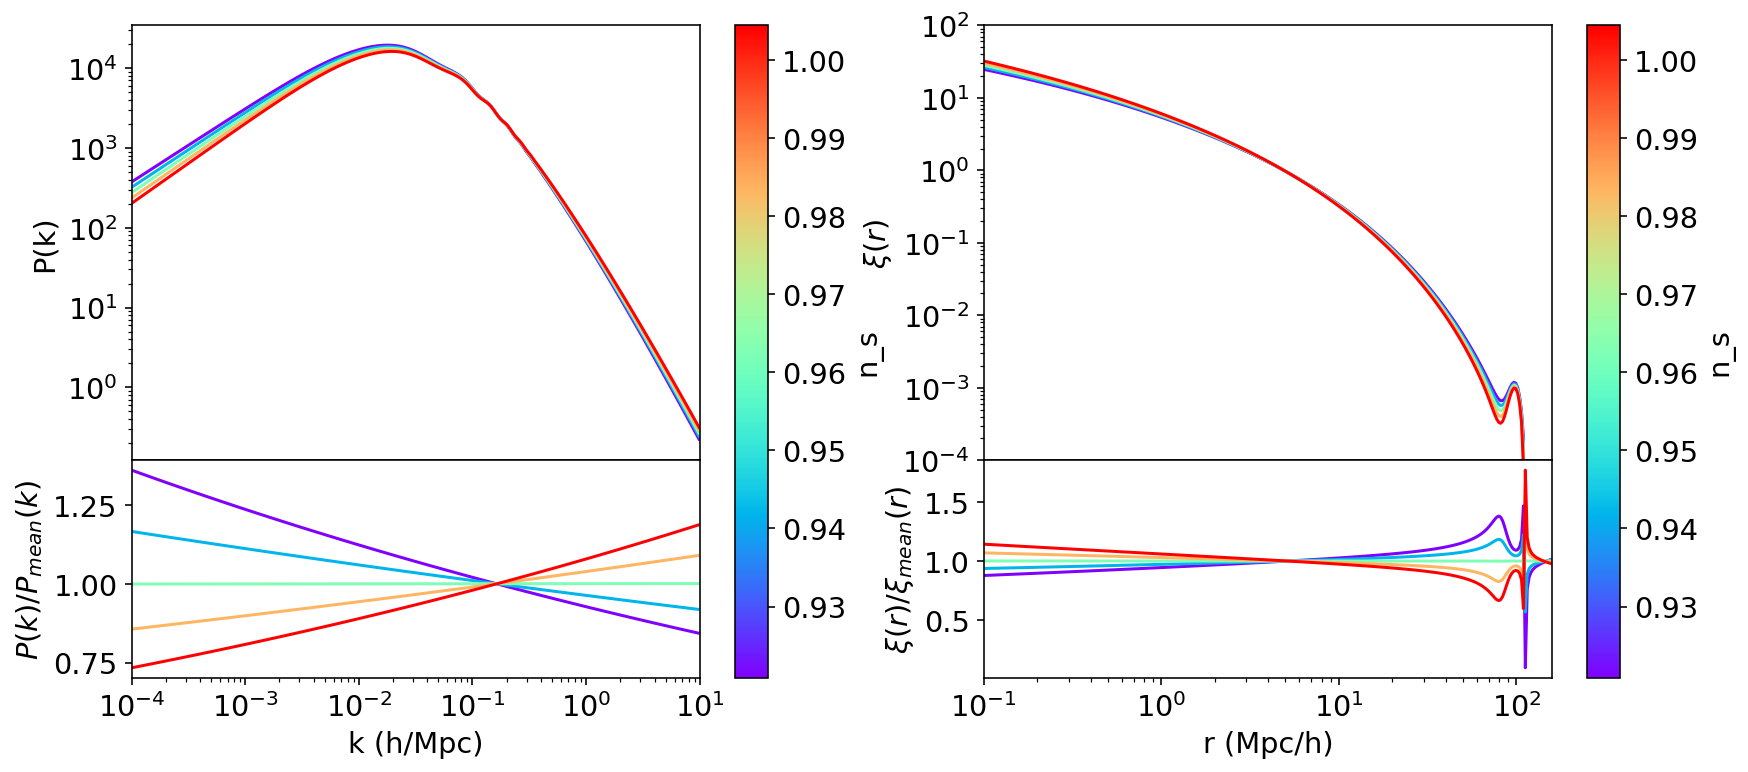

In [22]:
stats_theory = ['P(k)', r'$\xi(r)$']
stats_mean = ['$P(k)/P_{mean}(k)$', r'$\xi(r)/\xi_{mean}(r)$']
stats_base = [pk_base, xi_base]
stats_xlabels = ['k (h/Mpc)', "r (Mpc/h)"]
nrows = len(params)
ncols = len(stats_theory)

#panel_size = (4,7)
#figsize = (panel_size[1]*ncols, panel_size[0]*nrows)
figsize = (14,6)

for i in range(len(params)):
    fig, axarr = plt.subplots(2, ncols, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]})
    plt.subplots_adjust(hspace=0)
    
    param = params[i]
    print(param)
    #val_base = cosmo_dict[param]
    #val_min = 0.7*val_base
    #val_max = 1.3*val_base
    #vals = np.linspace(val_min, val_max, 5)
    pmin, pmax = emu_wp.get_param_bounds(params_emuname[i])
    vals = np.linspace(pmin, pmax, 5)
    
    ss, kk, xis, pks = [], [], [], []
    for val_new in vals:
        print(val_new)
            
        kws = {param:val_new}
        if param=='N_eff' or param=='sigma_8' or param=='w':
            cosmo_new = build_cosmo(pname=params_emuname[i], pval=val_new)
        else:
            cosmo_new = cosmology.Cosmology.clone(cosmo_base, **kws)
        #for keyy,vall in cosmo_new:
        #    print(f'{keyy}: {vall}')        
        
        Plin = cosmology.LinearPower(cosmo_new, redshift, transfer='EisensteinHu')
        CF = cosmology.correlation.CorrelationFunction(Plin)
        
        kk.append(k)
        pks.append(Plin(k))
        ss.append(s)
        xis.append(CF(s))
        
    stats = [pks, xis]
    xvals = [kk, ss]
    for j in range(ncols):
    
        axtop = axarr[0][j]
        axbot = axarr[1][j]
    
        lc = multiline(xvals[j], stats[j], vals, cmap='rainbow', ax=axtop)
        ratio = stats[j]/stats_base[j]
        lc = multiline(xvals[j], ratio, vals, cmap='rainbow', ax=axbot)
        

        axcb = fig.colorbar(lc, ax=[axtop,axbot])
        axcb.set_label(param)

        axtop.set_xscale('log')
        axbot.set_xscale('log')
        
        if j==1:
            axtop.set_ylim(10**-4, 10**2)
        axbot.set_xlabel(stats_xlabels[j])
        axtop.set_xticks([])
        
        axtop.set_xlim(min(xvals[j][0]), max(xvals[j][0]))
        axbot.set_xlim(min(xvals[j][0]), max(xvals[j][0]))

        axtop.set_yscale("log") 
        axtop.set_ylabel(stats_theory[j])
        axbot.set_ylabel(stats_mean[j])
        
        if param=='Omega_m' and j==1:
            axbot.set_ylim(0, 2.5)
        if param=='Omega_b' and j==1:
            axbot.set_ylim(0, 3)

### Omega_m
larger Omega_m -> matter dominated more strongly in early u, leading to earlier mat/rad equality -> smaller equality scale -> larger k_eq -> **above k_eq, power spec has larger amplitude & below k_eq, power spec has smaller amplitude**

### Omega_b
larger Omega_b -> inertia of baryons means slower effective sound speed -> acoustic waves don't travel as far by recombination -> smaller sound horizon scale -> **BAO peak to smaller r** 

larger Omega_b -> driving force of gravitational potential dominates more over fluid pressure -> oscillation amplitude enhanced -> **larger amplitude of BAO oscillations & peak** (WHY??)

### sigma_8
larger sigma_8 -> p(k) normalized to higher amplitudes -> **p(k) larger at all scales** BUT WHY??

width of probability distribution increases -> bc more nonlinear -> higher probability for high density because of gravitational collapse (nonlinear process) -> **higher p(k) amplitude** ???

### h
larger h -> larger k_eq because k_eq proportional to Omega_m * h^2 (FIGURE OUT WHY EXACTLY) and get another h dependence from units Mpc/h) -> same as increasing Omega_m, **above k_eq, power spec has larger amplitude & below k_eq, power spec has smaller amplitude**

larger h -> smaller sound horizon -> BAO peak to smaller scales -> but subdominant to other effects (?)

### n_s
larger n_s -> p(k) ~ k^(n_s) at small k -> steeper positive slope at small k -> **p(k) amplitude smaller at small k**

larger n_s -> p(k) ~ k^(n_s - 4) at large k -> less negative slope at large k -> **p(k) amplitude larger at large k**

### w
more negative w -> dark energy stronger -> supresses clustering -> **p(k) amplitude smaller at all k**

((mathematically why tho??))

### N_eff
increasing Neff -> decreases ratio of baryons to cdm (??) -> enhancement of small scale p(k) (??) & 
increasing Neff -> decreases ratio of baryons to cdm (??) -> damps BAO peaks & BAO peak to smaller r (see above) (??)

## Questions

Why does the behavior change around the one-halo vs two-halo term for cosmological parameters? Is it coincidence that its close to the Keq scale? 

From power spectrum to xi(r) - just reflect change in amplitudes from k to r?

From xi(r) to w_p(r_p) - is it different?

Bao - why combine dA and H(z) in this way to get d_v? A: just bc two dimensions of dA in plane of sky and one along los in H(z)! but not used much

Omega_cdm
0.2460299
0.2751332
0.3042365
0.3333398
0.3624431
Omega_b
0.03664212
0.043423260000000005
0.0502044
0.05698554
0.06376668


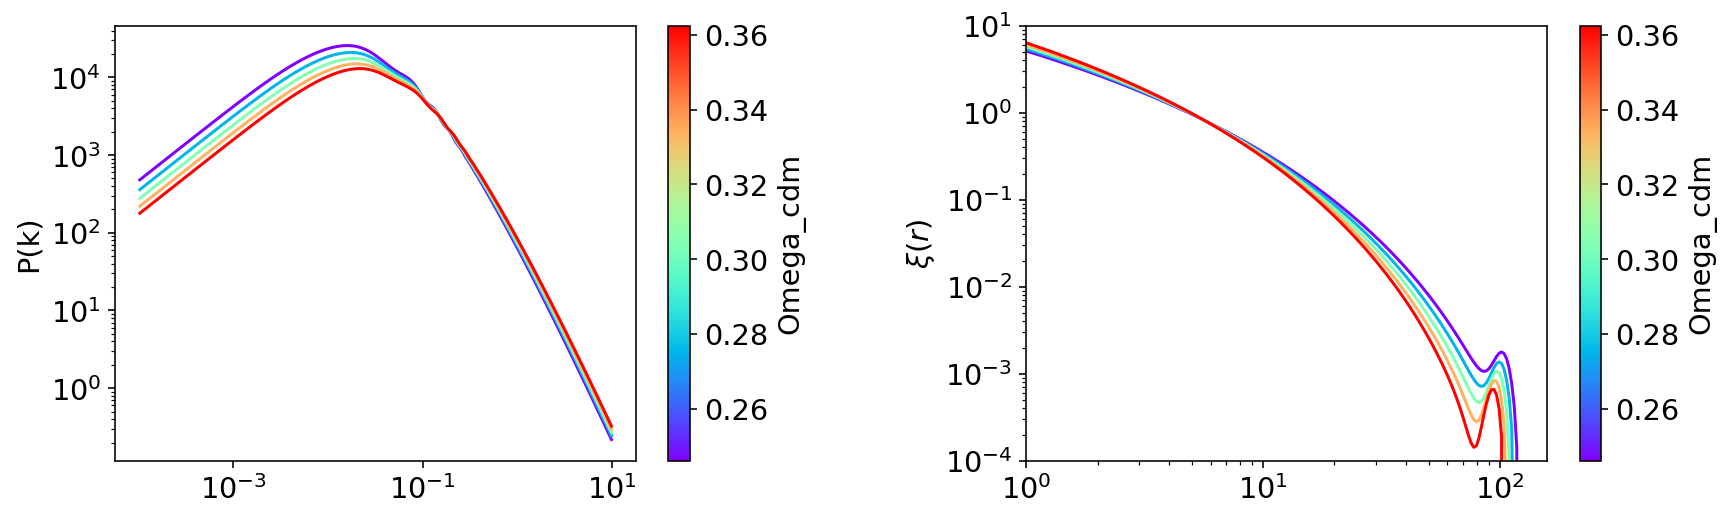

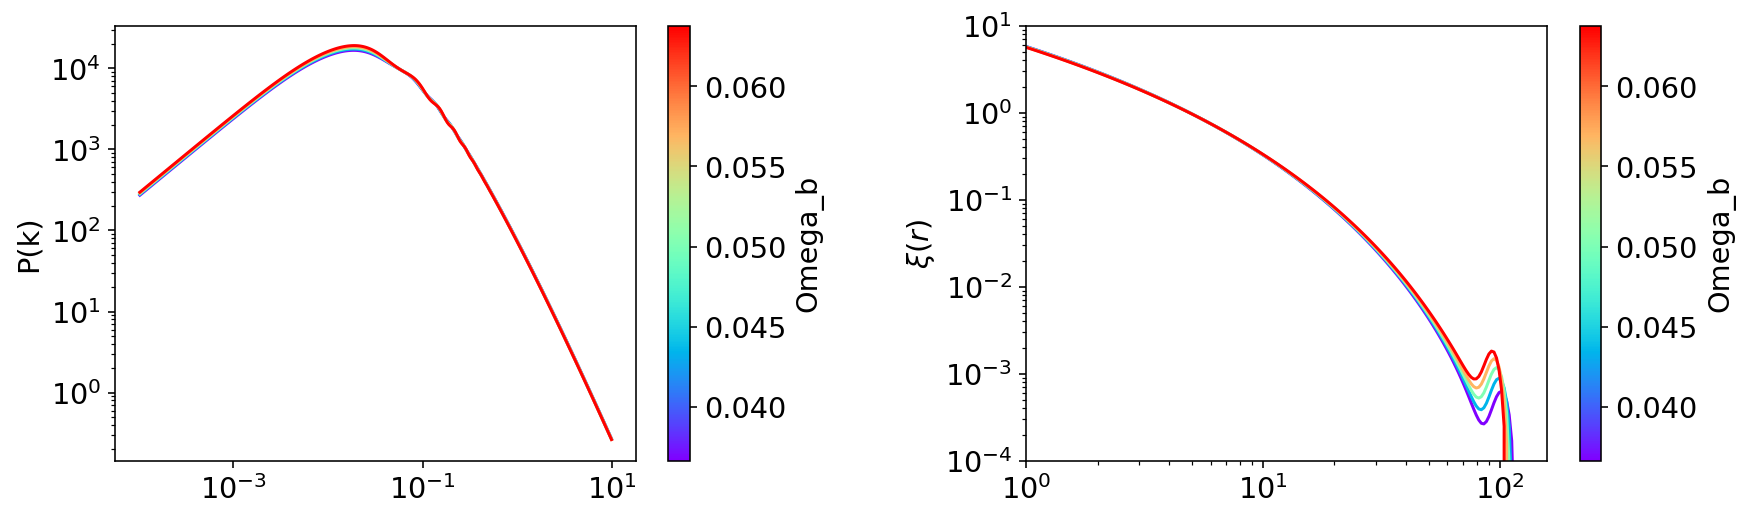

In [29]:
params = ['Omega_cdm', 'Omega_b']
params_emuname = ['Omega_m', 'Omega_b']

stats_theory = ['P(k)', r'$\xi(r)$']
stats_mean = ['$P(k)/P_{mean}(k)$', r'$\xi(r)/\xi_{mean}(r)$']
stats_base = [pk_base, xi_base]
stats_xlabels = ['k (h/Mpc)', "r (Mpc/h)"]
nrows = len(params)
ncols = len(stats_theory)

#panel_size = (4,7)
#figsize = (panel_size[1]*ncols, panel_size[0]*nrows)
figsize = (14,4)

show_mean = False

for i in range(len(params)):
    if show_mean:
        fig, axarr = plt.subplots(2, ncols, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]})
        plt.subplots_adjust(hspace=0)
    else:
        fig, axarr = plt.subplots(1, ncols, figsize=figsize)
        plt.subplots_adjust(wspace=0.4)


    
    param = params[i]
    print(param)
    #val_base = cosmo_dict[param]
    #val_min = 0.7*val_base
    #val_max = 1.3*val_base
    #vals = np.linspace(val_min, val_max, 5)
    pmin, pmax = emu_wp.get_param_bounds(params_emuname[i])
    vals = np.linspace(pmin, pmax, 5)
    
    ss, kk, xis, pks = [], [], [], []
    for val_new in vals:
        print(val_new)
            
        kws = {param:val_new}
        if param=='N_eff' or param=='sigma_8' or param=='w':
            cosmo_new = build_cosmo(pname=params_emuname[i], pval=val_new)
        else:
            cosmo_new = cosmology.Cosmology.clone(cosmo_base, **kws)
        #for keyy,vall in cosmo_new:
        #    print(f'{keyy}: {vall}')        
        
        Plin = cosmology.LinearPower(cosmo_new, redshift, transfer='EisensteinHu')
        CF = cosmology.correlation.CorrelationFunction(Plin)
        
        kk.append(k)
        pks.append(Plin(k))
        ss.append(s)
        xis.append(CF(s))
        
    stats = [pks, xis]
    xvals = [kk, ss]
    for j in range(ncols):
    
        
        if show_mean:
            axbot = axarr[1][j]
            axtop = axarr[0][j]
        else:
            axtop = axarr[j]
    
        lc = multiline(xvals[j], stats[j], vals, cmap='rainbow', ax=axtop)
        ratio = stats[j]/stats_base[j]

        if show_mean:
            lc = multiline(xvals[j], ratio, vals, cmap='rainbow', ax=axbot)
            #axbot.set_xlim(min(xvals[j][0]), max(xvals[j][0]))
            axbot.set_ylabel(stats_mean[j])
            axtop.set_xticks([])
            axbot.set_xlabel(stats_xlabels[j])
            axbot.set_xscale('log')
            axs = [axtop, axbot]
        
        else:
            axs = [axtop]
            
        axcb = fig.colorbar(lc, ax=axs)
        axcb.set_label(param)

        axtop.set_xscale('log')
        
        
        if j==1:
            if show_mean:
                axbot.set_xlim(10**0, max(xvals[j][0]))
            axtop.set_xlim(10**0, max(xvals[j][0]))
            axtop.set_ylim(10**-4, 10**1)
        
            
        #axtop.set_xlim(min(xvals[j][0]), max(xvals[j][0]))
        axtop.set_yscale("log") 
        axtop.set_ylabel(stats_theory[j])
        
        
#         if param=='Omega_m' and j==1:
#             axbot.set_ylim(0, 2.5)
#         if param=='Omega_b' and j==1:
#             axbot.set_ylim(0, 3)

### See how close emus get given true params

In [9]:
cosmo = 3
hod = 3

cosmo_names = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w']
hod_names = ['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f',
                                   'f_env', 'delta_env', 'sigma_env']
param_names_ordered = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w',
                                    'M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f',
                                   'f_env', 'delta_env', 'sigma_env']

param_dict_true = {}
for hh in range(len(hod_names)):
    param_dict_true[hod_names[hh]] = hods_test[hod][hh]
for cc in range(len(cosmo_names)):
    param_dict_true[cosmo_names[cc]] = cosmos_test[cosmo][cc]

print(param_dict_true)

{'M_sat': 14.276009350823092, 'alpha': 1.438172, 'M_cut': 12.415368710007556, 'sigma_logM': 0.2861269, 'v_bc': 0.5629193, 'v_bs': 0.6943786, 'c_vir': 1.906767, 'f': 0.5601679, 'f_env': -0.1069814, 'delta_env': 1.687248, 'sigma_env': 0.8692401, 'Omega_m': 0.289014, 'Omega_b': 0.0434999, 'sigma_8': 0.859613, 'h': 0.707317, 'n_s': 0.953515, 'N_eff': 3.7, 'w': -1.13151}


In [10]:
emu_wp.predict(param_dict_true)

predict
{'M_sat': 14.276009350823092, 'alpha': 1.438172, 'M_cut': 12.415368710007556, 'sigma_logM': 0.2861269, 'v_bc': 0.5629193, 'v_bs': 0.6943786, 'c_vir': 1.906767, 'f': 0.5601679, 'f_env': -0.1069814, 'delta_env': 1.687248, 'sigma_env': 0.8692401, 'Omega_m': 0.289014, 'Omega_b': 0.0434999, 'sigma_8': 0.859613, 'h': 0.707317, 'n_s': 0.953515, 'N_eff': 3.7, 'w': -1.13151}


array([2839.57123062, 1168.74395175,  492.09729913,  229.52203931,
        124.82488844,   73.33534231,   39.2415394 ,   17.23491087,
          5.03197528])

In [12]:
param_dict_min = param_dict_true.copy()
param_dict_min['Omega_m'] = 0.32187613
param_dict_min['sigma_8'] = 0.82621898
emu_wp.predict(param_dict_min)

predict
{'M_sat': 14.276009350823092, 'alpha': 1.438172, 'M_cut': 12.415368710007556, 'sigma_logM': 0.2861269, 'v_bc': 0.5629193, 'v_bs': 0.6943786, 'c_vir': 1.906767, 'f': 0.5601679, 'f_env': -0.1069814, 'delta_env': 1.687248, 'sigma_env': 0.8692401, 'Omega_m': 0.32187613, 'Omega_b': 0.0434999, 'sigma_8': 0.82621898, 'h': 0.707317, 'n_s': 0.953515, 'N_eff': 3.7, 'w': -1.13151}


array([2866.27132974, 1176.14506987,  480.72240848,  219.56322316,
        120.79668472,   68.54019573,   34.61882448,   15.93242161,
          4.97247702])

In [15]:
cov = np.loadtxt(f"../../clust/results_minerva/corrmat_minerva_{statistic}.dat")
print("Covariance:")
print(cov.shape)
for i in range(len(cov)):
    cov[i][i] = emu_wp.gperr[i]
combined_inv_cov = np.linalg.inv(cov)

Covariance:
(9, 9)


In [17]:
statistic = 'wp'
testtag = '_mean_test0'
res_dir = '../../clust/results_{}/'.format(statistic)
testing_dir = '{}testing_{}{}/'.format(res_dir, statistic, testtag) 
fn = testing_dir + f'wp_cosmo_{cosmo}_HOD_{hod}_mean.dat'
rs, ys = np.loadtxt(fn)
print(vals)

[2861.2744    1171.0072     481.59148    226.24992    123.5163
   73.42277     39.406038    17.304958     5.5218626]


In [26]:
pname = 'sigma_8'

In [27]:
likes = []
pmin, pmax = emu_wp.get_param_bounds(pname)
pgrid = np.linspace(pmin, pmax, 50)
for pval in pgrid:
    param_dict_point = param_dict_true.copy()
    param_dict_point[pname] = pval
    emu_pred = emu_wp.predict(param_dict_point)
    
    diff = np.array(emu_pred) - np.array(ys)
    like = -np.dot(diff, np.dot(combined_inv_cov, diff.T).T) / 2.0
    likes.append(like)

In [32]:
print(pgrid[np.argmax(likes)])
print(param_dict_true[pname])

0.860236953877551
0.859613


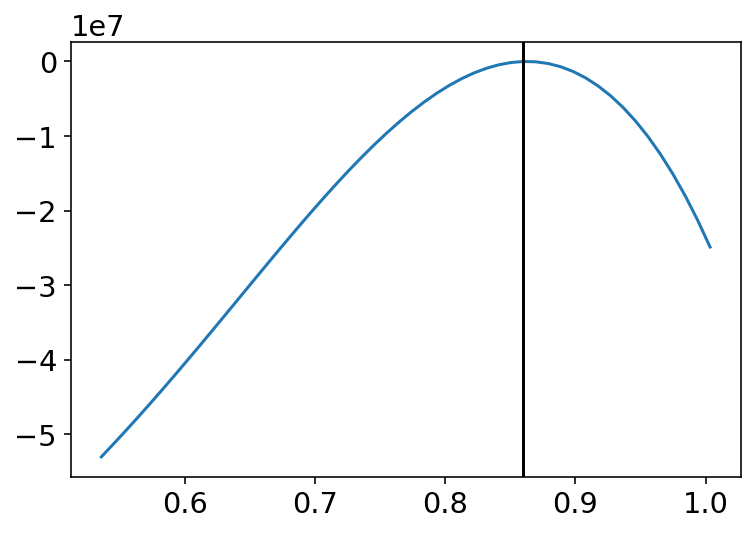

In [28]:
plt.plot(pgrid, likes)
plt.axvline(param_dict_true[pname], color='k')

In [67]:
pname1 = 'Omega_m'
pname2 = 'sigma_8'

nside = 20
pmin1, pmax1 = emu_wp.get_param_bounds(pname1)
pgrid1 = np.linspace(pmin1, pmax1, nside)

pmin2, pmax2 = emu_wp.get_param_bounds(pname2)
pgrid2 = np.linspace(pmin2, pmax2, nside)

likes = np.empty((nside, nside))

for i in range(len(pgrid1)):
    for j in range(len(pgrid2)):
        print(i,j)
        param_dict_point = param_dict_true.copy()
        param_dict_point[pname1] = pgrid1[i]
        param_dict_point[pname2] = pgrid2[j]
        emu_pred = emu_wp.predict(param_dict_point)

        diff = np.array(emu_pred) - np.array(ys)
        like = -np.dot(diff, np.dot(combined_inv_cov, diff.T).T) / 2.0
        likes[i][j] = like

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10

In [68]:
print(likes.shape)
ind = np.unravel_index(np.argmax(likes, axis=None), likes.shape)
print(ind)
print(pgrid1[ind[0]], pgrid2[ind[1]])
print(param_dict_true[pname1], param_dict_true[pname2])

(20, 20)
(8, 13)
0.2950459842105263 0.8557148326315789
0.289014 0.859613


In [69]:
likes

array([[-5.71205425e+07, -5.30229570e+07, -4.87004249e+07,
        -4.41820405e+07, -3.95105609e+07, -3.47425075e+07,
        -2.99474506e+07, -2.52060750e+07, -2.06069381e+07,
        -1.62421967e+07, -1.22038456e+07, -8.58403158e+06,
        -5.47703277e+06, -2.97826600e+06, -1.18195373e+06,
        -1.81644532e+05, -7.41227347e+04, -9.62942044e+05,
        -2.96288373e+06, -6.20592606e+06],
       [-5.65501972e+07, -5.23772919e+07, -4.79762795e+07,
        -4.33788331e+07, -3.86308934e+07, -3.37928086e+07,
        -2.89386058e+07, -2.41539688e+07, -1.95328266e+07,
        -1.51729065e+07, -1.11719240e+07, -7.62792564e+06,
        -4.64120009e+06, -2.31316891e+06, -7.44136963e+05,
        -3.40891543e+04, -2.86742032e+05, -1.61327288e+06,
        -4.13729387e+06, -8.00123072e+06],
       [-5.59753997e+07, -5.17270157e+07, -4.72476864e+07,
        -4.25717962e+07, -3.77486307e+07, -3.28425527e+07,
        -2.79322608e+07, -2.31086750e+07, -1.84713557e+07,
        -1.41238801e+07, -1.0

In [70]:
likes[8][9]

-8368157.558845583

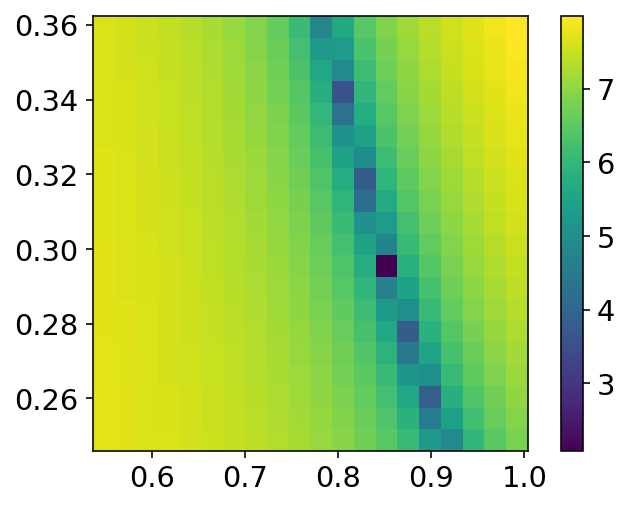

In [71]:
ax = plt.gca()
plt.imshow(np.log10(-likes), extent=[pmin2, pmax2, pmin1, pmax1], aspect=(pmax2-pmin2)/(pmax1-pmin1), origin='lower')
plt.colorbar()

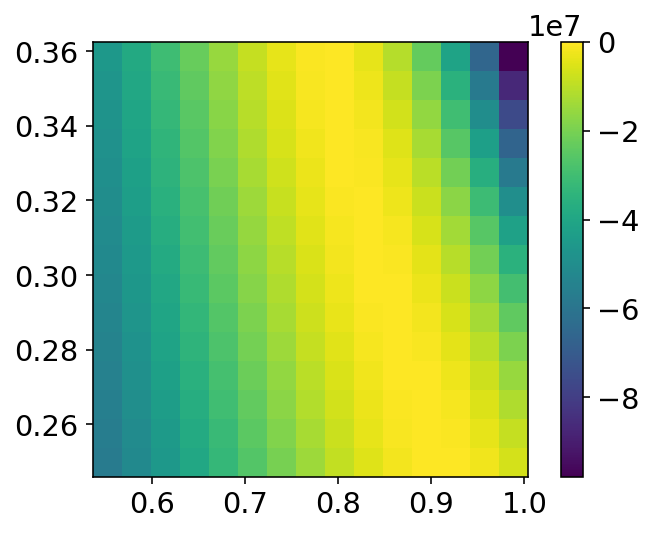

In [63]:
ax = plt.gca()
plt.imshow(likes, extent=[pmin2, pmax2, pmin1, pmax1], aspect=(pmax2-pmin2)/(pmax1-pmin1), origin='lower')
plt.colorbar()


In [88]:
pname1 = 'sigma_8'
pname2 = 'w'

nside = 15
pmin1, pmax1 = emu_wp.get_param_bounds(pname1)
pgrid1 = np.linspace(pmin1, pmax1, nside)

pmin2, pmax2 = emu_wp.get_param_bounds(pname2)
pgrid2 = np.linspace(pmin2, pmax2, nside)

likes = np.empty((nside, nside))

for i in range(len(pgrid1)):
    print(i)
    for j in range(len(pgrid2)):
        param_dict_point = param_dict_true.copy()
        param_dict_point[pname1] = pgrid1[i]
        param_dict_point[pname2] = pgrid2[j]
        emu_pred = emu_wp.predict(param_dict_point)

        diff = np.array(emu_pred) - np.array(ys)
        like = -np.dot(diff, np.dot(combined_inv_cov, diff.T).T) / 2.0
        likes[i][j] = like

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [89]:
print(likes.shape)
ind = np.unravel_index(np.argmax(likes, axis=None), likes.shape)
print(ind)
print(pgrid1[ind[0]], pgrid2[ind[1]])
print(param_dict_true[pname1], param_dict_true[pname2])

(15, 15)
(10, 3)
0.8697836542857142 -1.26885248
0.859613 -1.13151


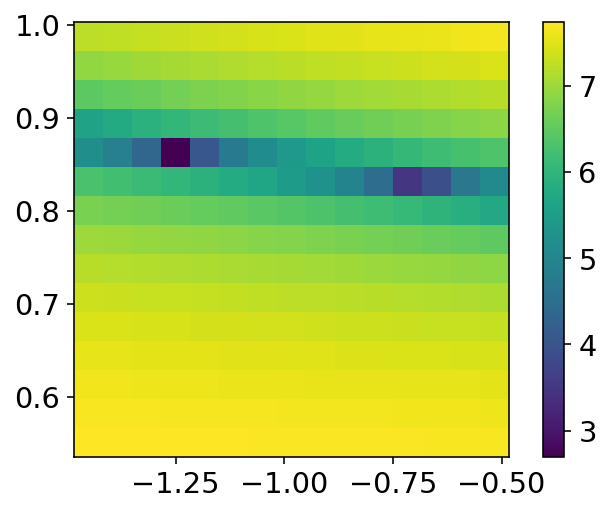

In [90]:
ax = plt.gca()
plt.imshow(np.log10(-likes), extent=[pmin2, pmax2, pmin1, pmax1], aspect=(pmax2-pmin2)/(pmax1-pmin1), origin='lower')
plt.colorbar()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
(15, 15)
(5, 9)
0.28760604285714286 14.270008507560613
0.289014 14.276009350823092


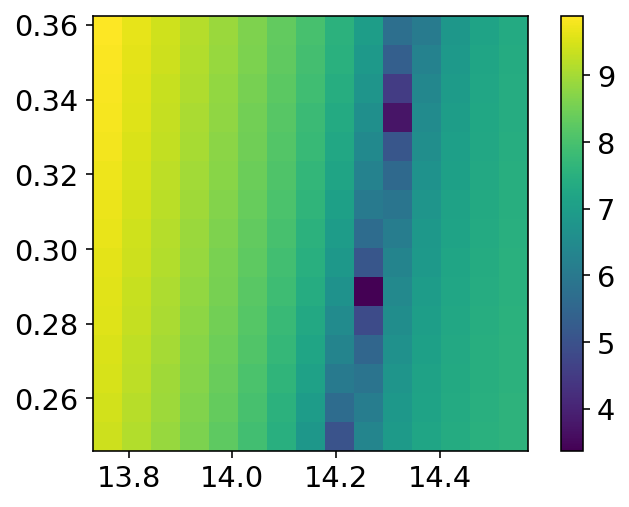

In [93]:
pname1 = 'Omega_m'
pname2 = 'M_sat'

nside = 15
pmin1, pmax1 = emu_wp.get_param_bounds(pname1)
pgrid1 = np.linspace(pmin1, pmax1, nside)

pmin2, pmax2 = emu_wp.get_param_bounds(pname2)
pgrid2 = np.linspace(pmin2, pmax2, nside)

likes = np.empty((nside, nside))

for i in range(len(pgrid1)):
    print(i)
    for j in range(len(pgrid2)):
        param_dict_point = param_dict_true.copy()
        param_dict_point[pname1] = pgrid1[i]
        param_dict_point[pname2] = pgrid2[j]
        emu_pred = emu_wp.predict(param_dict_point)

        diff = np.array(emu_pred) - np.array(ys)
        like = -np.dot(diff, np.dot(combined_inv_cov, diff.T).T) / 2.0
        likes[i][j] = like
        
print(likes.shape)
ind = np.unravel_index(np.argmax(likes, axis=None), likes.shape)
print(ind)
print(pgrid1[ind[0]], pgrid2[ind[1]])
print(param_dict_true[pname1], param_dict_true[pname2])

ax = plt.gca()
plt.imshow(np.log10(-likes), extent=[pmin2, pmax2, pmin1, pmax1], aspect=(pmax2-pmin2)/(pmax1-pmin1), origin='lower')
plt.colorbar()